## Recommender Systems Course Final Project

Develop a recommender system that suggests short videos to users based on user preferences, interaction histories, and video content using the KuaiRec dataset. The challenge is to create a personalised and scalable recommendation engine similar to those used in platforms like TikTok or Kuaishou.

We declare here the different librairies that we will need to do the project. **DONT FORGET TO CHANGE THE DATA PATHS**

In [ ]:
# Import libraries
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import functions as F

import matplotlib.pyplot as plt
import logging

# CHANGE THIS TO YOUR PATH:
import os
os.environ["PYSPARK_PYTHON"] = "/usr/local/bin/python3.10"
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/local/python3.10"

# CHANGE THIS TO YOUR PATH:

DATA_PATH = "data_final_project/KuaiRec 2.0/data"

logging.getLogger().setLevel(logging.INFO)
logging.getLogger().setLevel(logging.INFO)

# Set plot parameters
plt.rcParams["figure.figsize"] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"
n = 5000


## Spark session creation

We create here the spark session that we will use throughout the project

In [2]:
spark = SparkSession.builder.appName("ALSMatrixFactorisation").config("spark.executor.memory", "16g").config("spark.driver.memory", "16g").config("spark.kryoserializer.buffer", "1m").config("spark.kryoserializer.buffer.max", "512m").config("spark.serializer", "org.apache.spark.serializer.KryoSerializer").getOrCreate()

your 131072x1 screen size is bogus. expect trouble
25/05/17 21:57:05 WARN Utils: Your hostname, DESKTOP-VP2ONCK resolves to a loopback address: 127.0.1.1; using 172.21.14.224 instead (on interface eth0)
25/05/17 21:57:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/17 21:57:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data loading

This project uses several datasets from the KuaiRec 2.0 collection, each providing different aspects of user interactions and content information for building a recommender system:

- **big_matrix.csv**  
  Contains the main user-item interaction data for the entire platform. Each row represents an interaction between a user and a video, including features such as user ID, video ID, watch ratio, timestamp, and other engagement metrics. This dataset is large and sparse, reflecting the full diversity of user behaviors, including both active and inactive users.

- **small_matrix.csv**  
  A filtered subset of the big matrix, focusing on highly active users. Every user in this dataset has a substantial number of interactions, making it suitable for robust evaluation of recommendation models. It is less sparse and smaller in size compared to the big matrix.

- **social_network.csv**  
  Describes the social relationships between users on the platform.

- **item_categories.csv**  
  Provides category information for each video. Each row links a video ID to a list of category labels, representing the content types or genres associated with the video. This information is useful for content-based filtering and feature engineering.

- **item_daily_features.csv**  
  Contains daily aggregated statistics for each video, such as daily like counts and play counts. This allows for the calculation of popularity metrics (e.g., like ratio) and tracking content trends over time.


##

In [3]:
df_small_matrix = spark.read.csv(os.path.join(DATA_PATH,"small_matrix.csv"), header=True, inferSchema=True)
df_big_matrix = spark.read.csv(os.path.join(DATA_PATH,"big_matrix.csv"), header=True, inferSchema=True)
df_social_network = spark.read.csv(os.path.join(DATA_PATH,"social_network.csv"), header=True, inferSchema=True)
df_item_categories = spark.read.csv(os.path.join(DATA_PATH,"item_categories.csv"), header=True, inferSchema=True)
df_item_daily_features = spark.read.csv(os.path.join(DATA_PATH,"item_daily_features.csv"), header=True, inferSchema=True)

### Data Cleaning Functions

Before performing any analysis or building recommendation models, it is crucial to clean the raw data to ensure its quality and consistency. This section defines and applies data cleaning functions to each of the main datasets.

We remove duplicate rows, drop rows with any null values but also remove out of range watch_ratios.



In [4]:
MIN_INTERACTIONS = 5

def clean_data_interactions(df):
    # Remove duplicates
    df = df.dropDuplicates()

    # Remove null values
    df = df.dropna()

    # Remove out-of-range watch_ratio
    df = df.filter((col("watch_ratio") >= 0))

    # Remove null ids
    df = df.filter((col("user_id").isNotNull()) & (col("video_id").isNotNull()))

    return df

def clean_data(df):
    # Remove duplicates
    df = df.dropDuplicates()

    # Remove null values
    df = df.dropna()

    return df

df_big_matrix = clean_data_interactions(df_big_matrix)
df_small_matrix = clean_data_interactions(df_small_matrix)
df_social_network = clean_data(df_social_network)
df_item_categories = clean_data(df_item_categories)
df_item_daily_features = clean_data(df_item_daily_features)


## Exploratory Data Analysis

We will now analyze the data to see what we could use as training or testing to build a good system recommender.

In [5]:
df_big_matrix.show(5)
print(f"Shape of the big matrix: {df_big_matrix.count()} rows, {len(df_big_matrix.columns)} columns")
unique_users = df_big_matrix.select("user_id").distinct().count()
unique_posts = df_big_matrix.select("video_id").distinct().count()
print(f"Unique users: {unique_users}")
print(f"Unique posts: {unique_posts}")
print(f"Matrix sparsity: {df_big_matrix.count() / (unique_posts * unique_users) * 100}%")

+-------+--------+-------------+--------------+--------------------+--------+----------------+------------------+
|user_id|video_id|play_duration|video_duration|                time|    date|       timestamp|       watch_ratio|
+-------+--------+-------------+--------------+--------------------+--------+----------------+------------------+
|      0|    1986|        14418|          9467|2020-07-06 04:02:...|20200706|1.593979345847E9|1.5229745431498891|
|      0|    6834|        14202|         12867|2020-07-06 10:00:...|20200706|1.594000829185E9| 1.103753788761949|
|      0|    3722|          732|          6067|2020-07-08 00:57:...|20200708|1.594141036402E9|0.1206527113894841|
|      0|    8295|        13369|          6717|2020-07-09 05:52:...|20200709| 1.59424513189E9|1.9903230608902784|
|      0|    5257|            0|         13100|2020-08-01 00:54:...|20200801|1.596214496005E9|               0.0|
+-------+--------+-------------+--------------+--------------------+--------+-----------

Shape of the big matrix: 11564987 rows, 8 columns


Unique users: 7176
Unique posts: 10728


Matrix sparsity: 15.022560234753845%


### **Analysis of the Big Matrix Visualizations**

#### 1. **Top 20 Most Popular Videos**
- The bar chart shows that a few videos are watched by a large number of unique users, while most videos have much fewer viewers.

#### 2. **Bottom 20 Least Popular Videos**
- The least popular videos are watched by only one user each.
- This highlights the sparsity of the dataset: most videos are not widely seen, which is realistic for large content platforms.

#### 3. **Top 20 Most Active Users**
- A small number of users have a very high number of interactions (hundreds), while most users interact much less.

#### 4. **Bottom 20 Least Active Users**
- The least active users have only 5–8 interactions.
- This is expected in large-scale systems, where many users are only minimally active.


### **Relevance for Training a Recommendation Model**

- **Reflects Real-World Usage:**  
  The data distribution (many inactive users, many unpopular items, a few very active users and popular items) matches what is seen in real-world platforms. This makes the dataset highly relevant for training, as the model will learn to deal with both popular and niche content, as well as active and inactive users.

- **Sparsity:**  
  The matrix is sparse, which is typical for recommendation problems. Models like ALS are designed to handle this kind of data.

---

> **Note:** All visualizations are based on a random 5% sample (`fraction=0.05`) of the small matrix for efficiency and clarity. The full dataset is used for model evaluation.

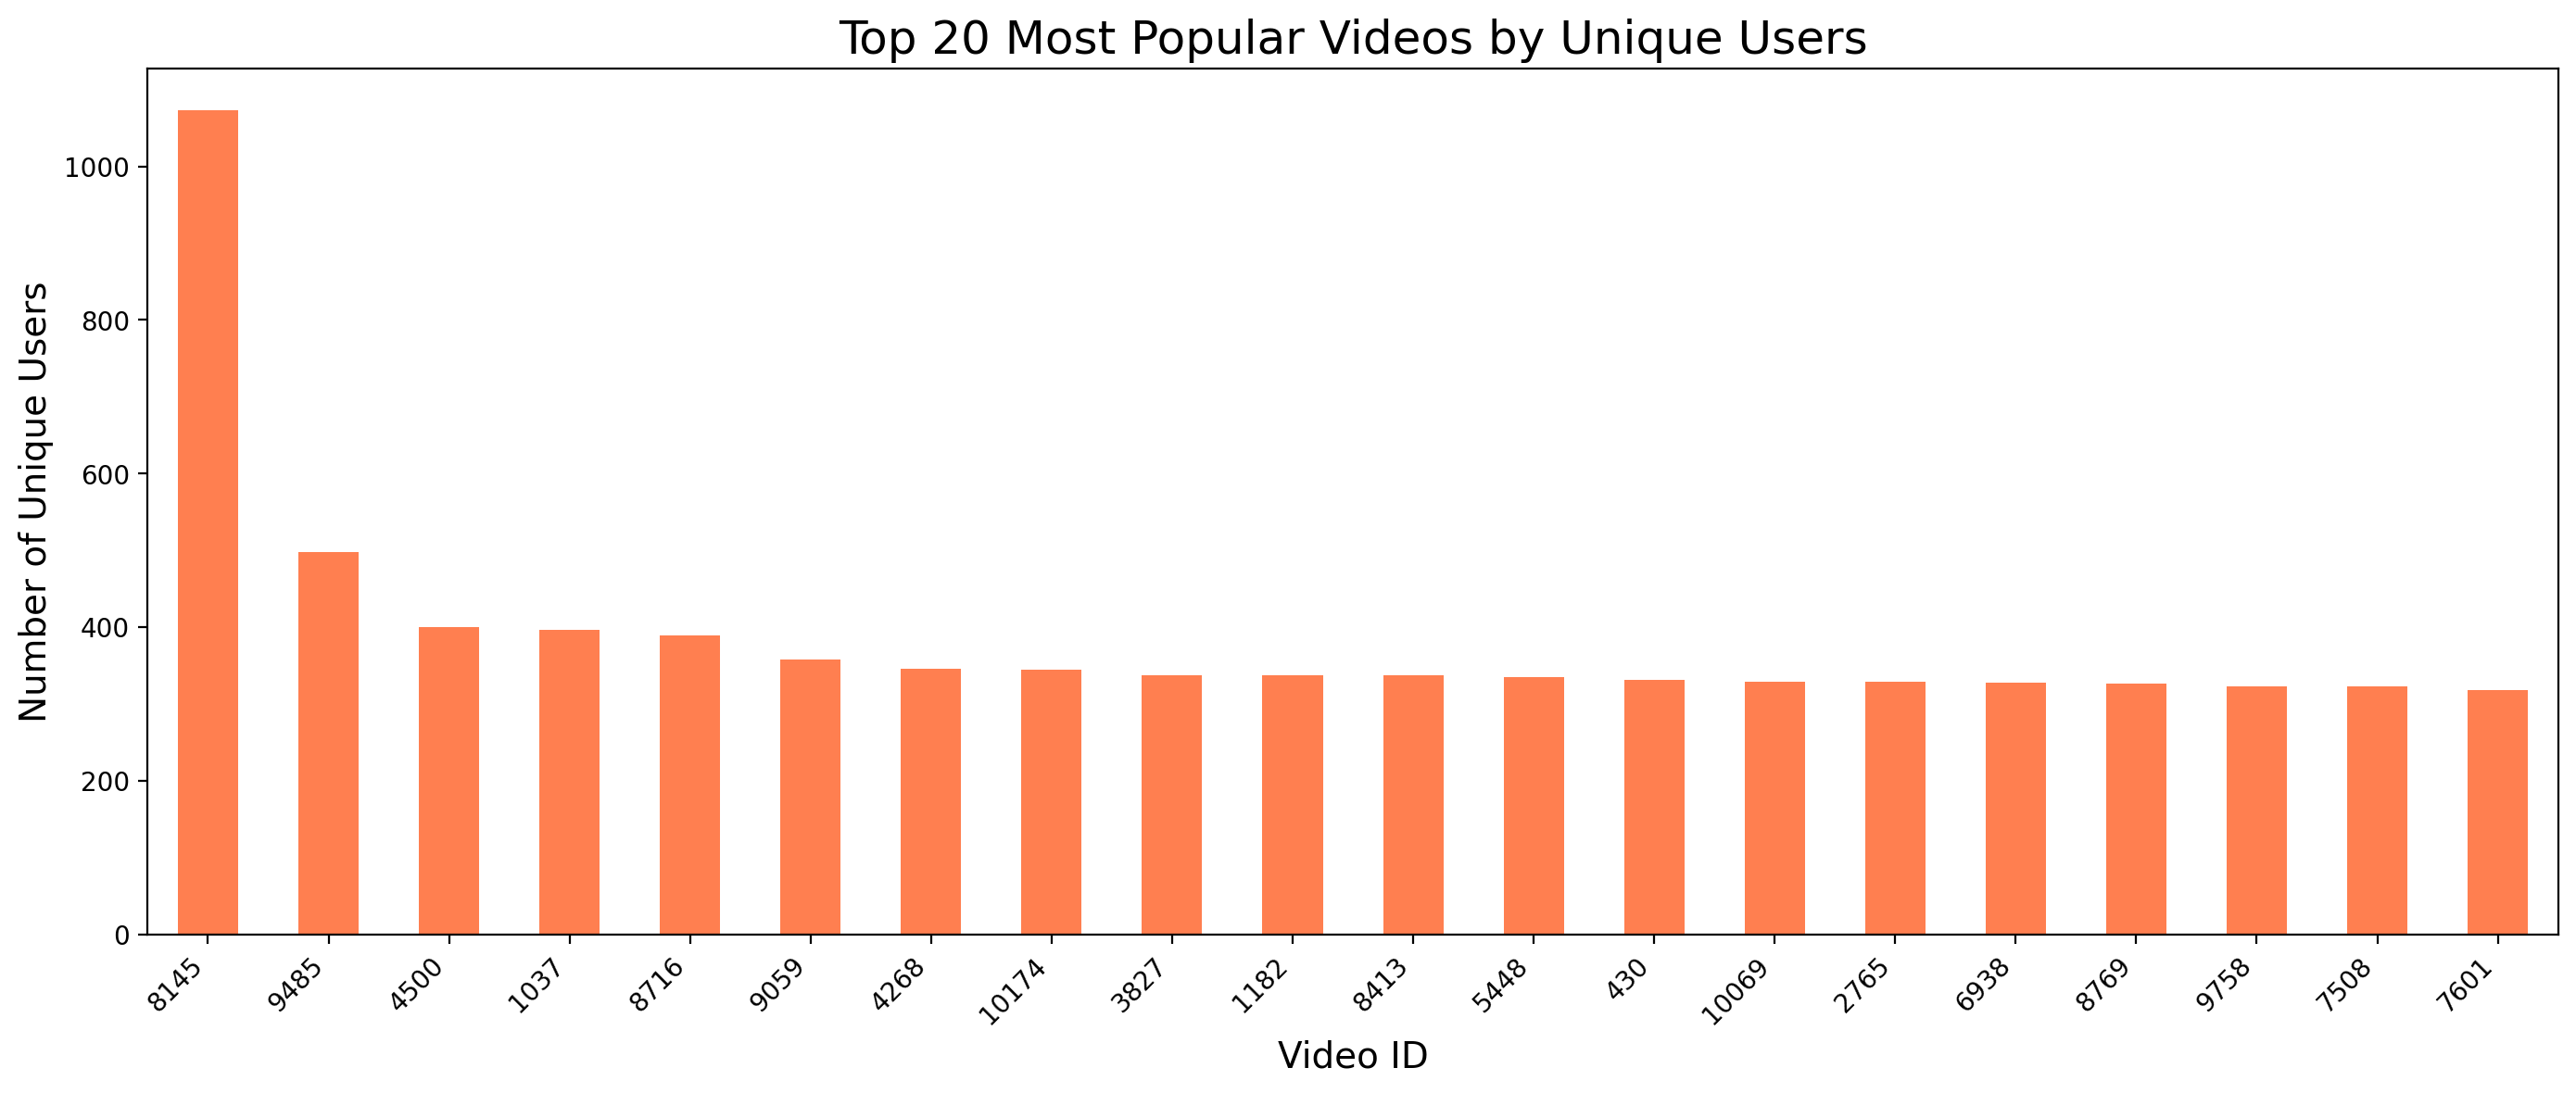

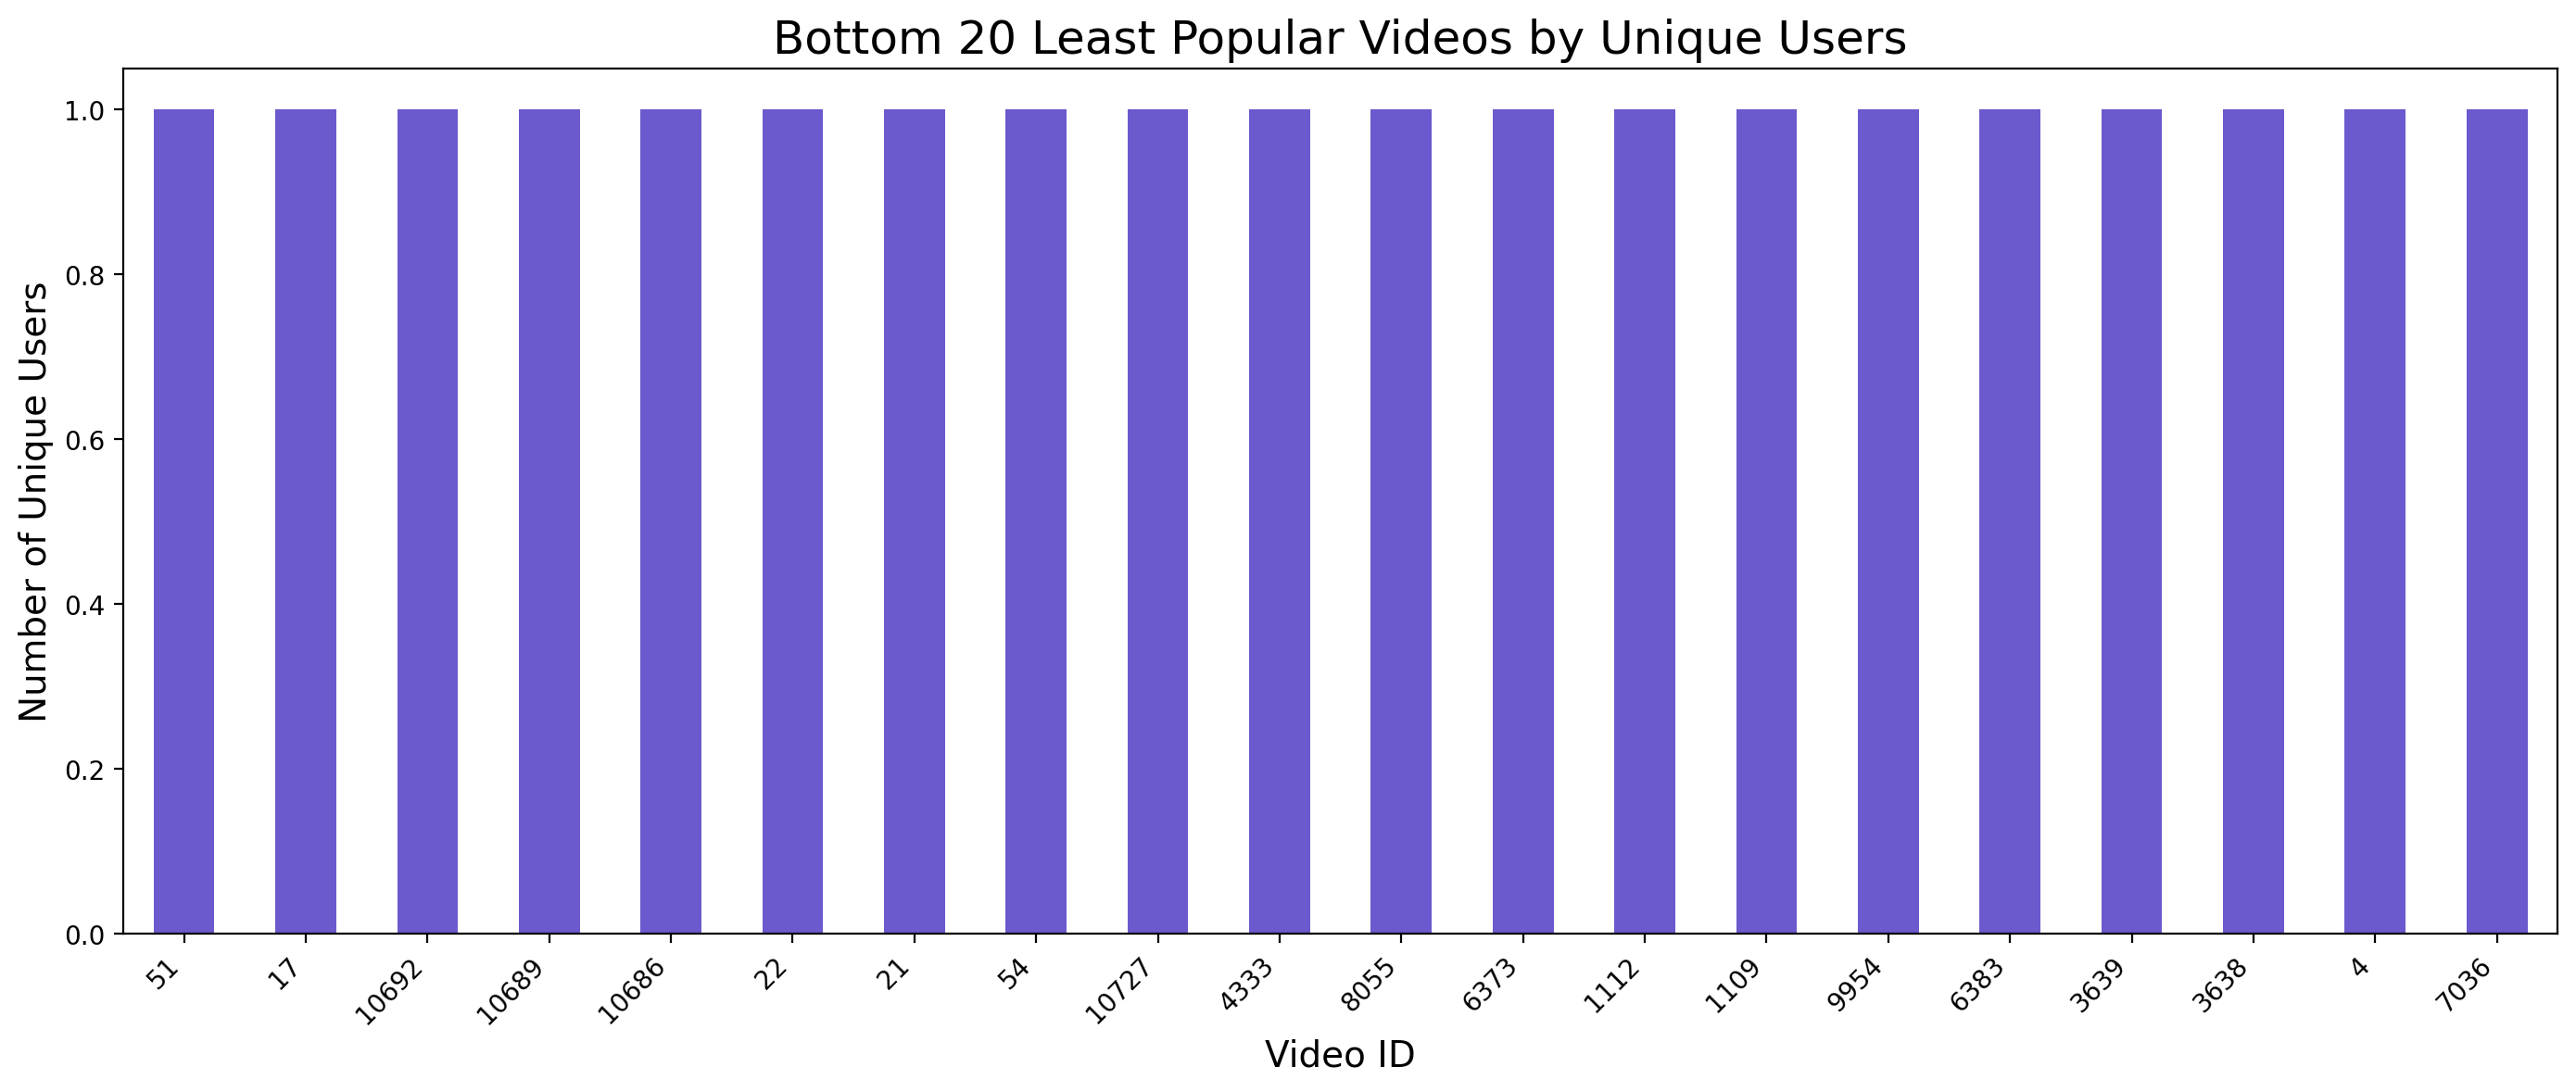

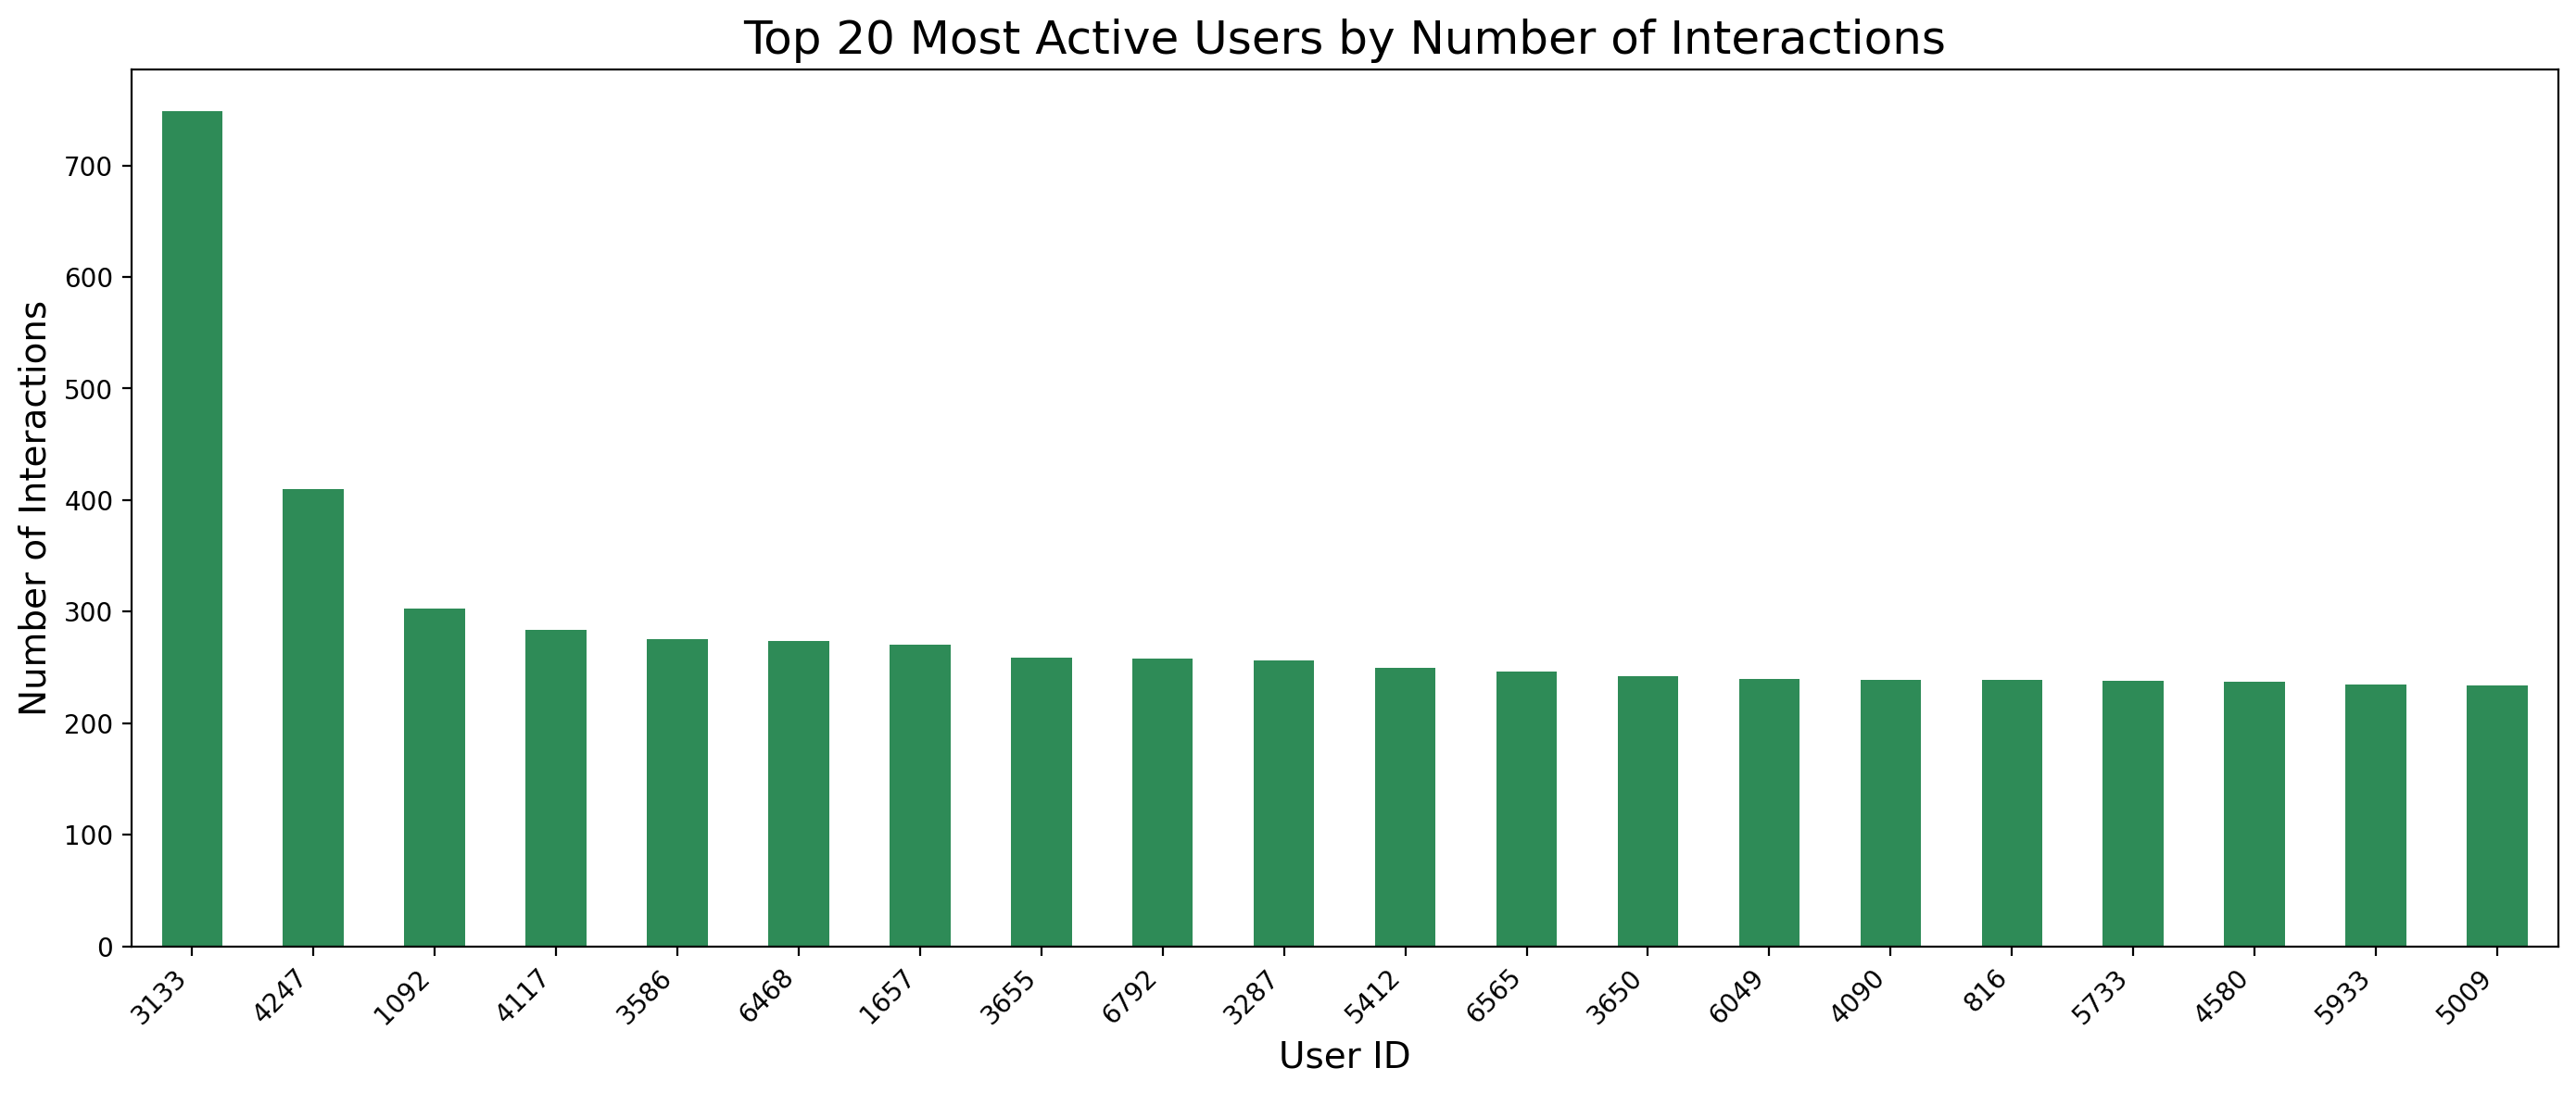

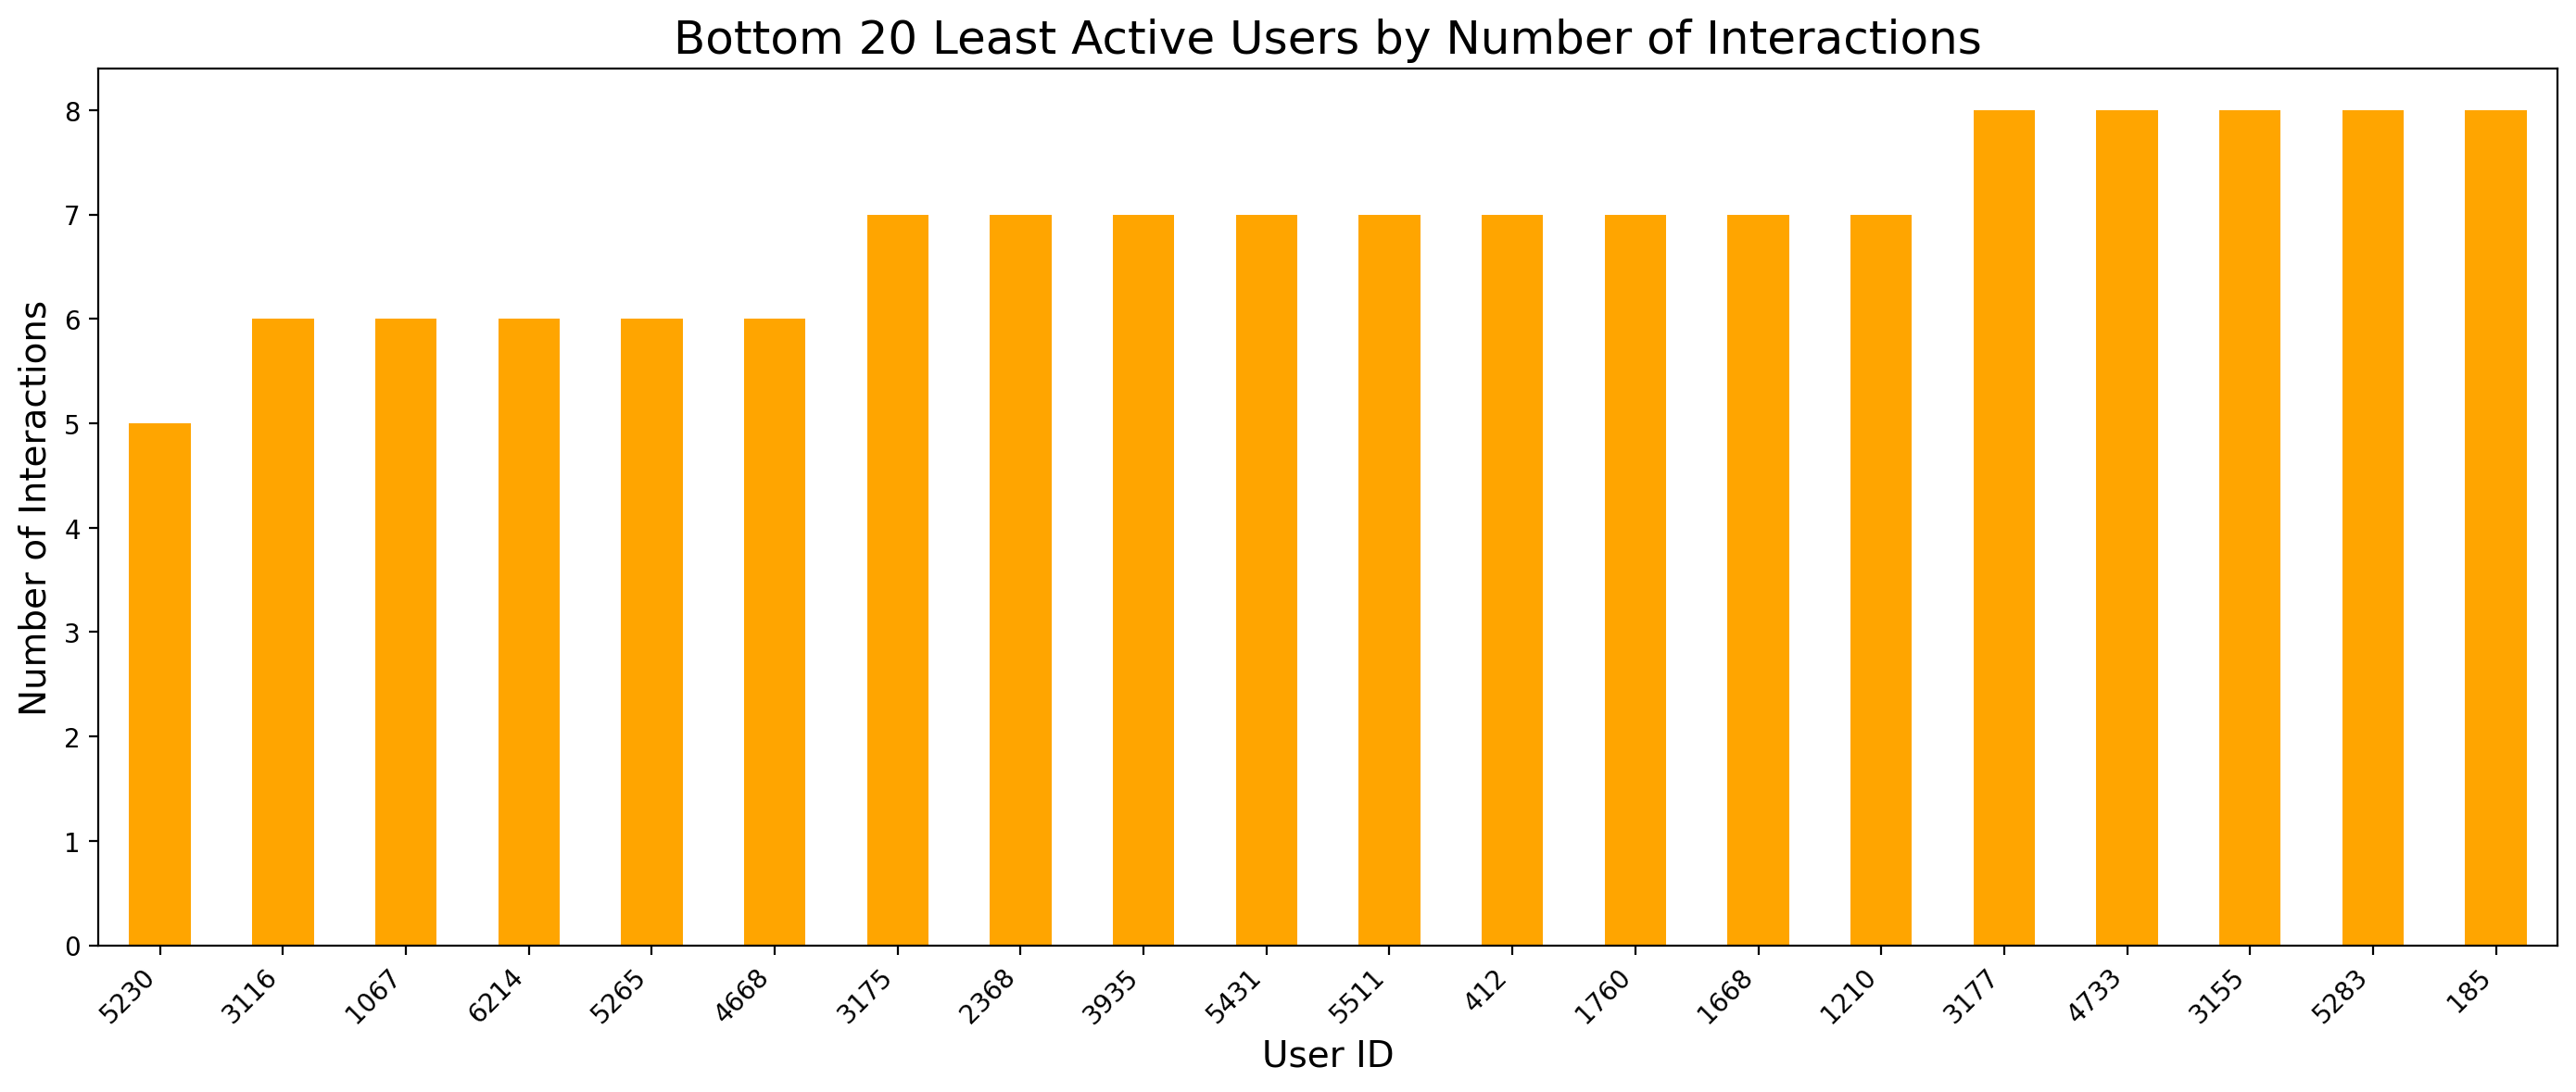

In [6]:
#Sample a manageable amount of data for visualization
big_matrix_pd = df_big_matrix.sample(fraction=0.05, seed=42).toPandas()

# Plot top 20 most popular videos by number of unique users
top_videos = (
    big_matrix_pd.groupby('video_id')['user_id']
    .nunique()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(14, 6))
top_videos.plot(kind='bar', color='coral')
plt.title('Top 20 Most Popular Videos by Unique Users', fontsize=18)
plt.xlabel('Video ID', fontsize=14)
plt.ylabel('Number of Unique Users', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

worst_videos = (
    big_matrix_pd.groupby('video_id')['user_id']
    .nunique()
    .sort_values(ascending=True)
    .head(20)
)

plt.figure(figsize=(14, 6))
worst_videos.plot(kind='bar', color='slateblue')
plt.title('Bottom 20 Least Popular Videos by Unique Users', fontsize=18)
plt.xlabel('Video ID', fontsize=14)
plt.ylabel('Number of Unique Users', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot number of interactions per user (top 20)
top_users = (
    big_matrix_pd.groupby('user_id')['video_id']
    .count()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(14, 6))
top_users.plot(kind='bar', color='seagreen')
plt.title('Top 20 Most Active Users by Number of Interactions', fontsize=18)
plt.xlabel('User ID', fontsize=14)
plt.ylabel('Number of Interactions', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

worst_users = (
    big_matrix_pd.groupby('user_id')['video_id']
    .count()
    .sort_values(ascending=True)
    .head(20)
)

plt.figure(figsize=(14, 6))
worst_users.plot(kind='bar', color='orange')
plt.title('Bottom 20 Least Active Users by Number of Interactions', fontsize=18)
plt.xlabel('User ID', fontsize=14)
plt.ylabel('Number of Interactions', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Interpretation of Temporal User Activity Analysis

1. Distribution of Activity by Hour:
The plot shows that user interactions are spread throughout the day, but there are clear peaks during late night and early morning hours (midnight to 4 AM and after 10 PM).
Activity dips in the afternoon (around 2–4 PM), suggesting users are less active during these hours.
This pattern may indicate that the platform's users are more engaged during late hours, possibly due to lifestyle or time zone effects.

2. Distribution of Activity by Day of Week:
The highest activity occurs on weekends (Saturday and Sunday), with Saturday being the peak.
Mondays and Fridays also show relatively high activity, while midweek days (especially Tuesday and Wednesday) are lower.
This suggests users are more active when they have more free time, such as weekends.

3. Interactions Over Time (by Date):
The time series plot reveals periods of high and low activity, with some sharp increases and decreases.
These fluctuations could be due to platform events, holidays, or data collection gaps.
Periods with zero activity may indicate missing data or times when the platform was offline.

4. Activity Patterns of Top 10 Users by Hour:
The most active users have diverse patterns, but many are most active at night, similar to the overall trend.
Some users are consistently active, while others have sharp peaks at specific hours, showing varied usage habits.


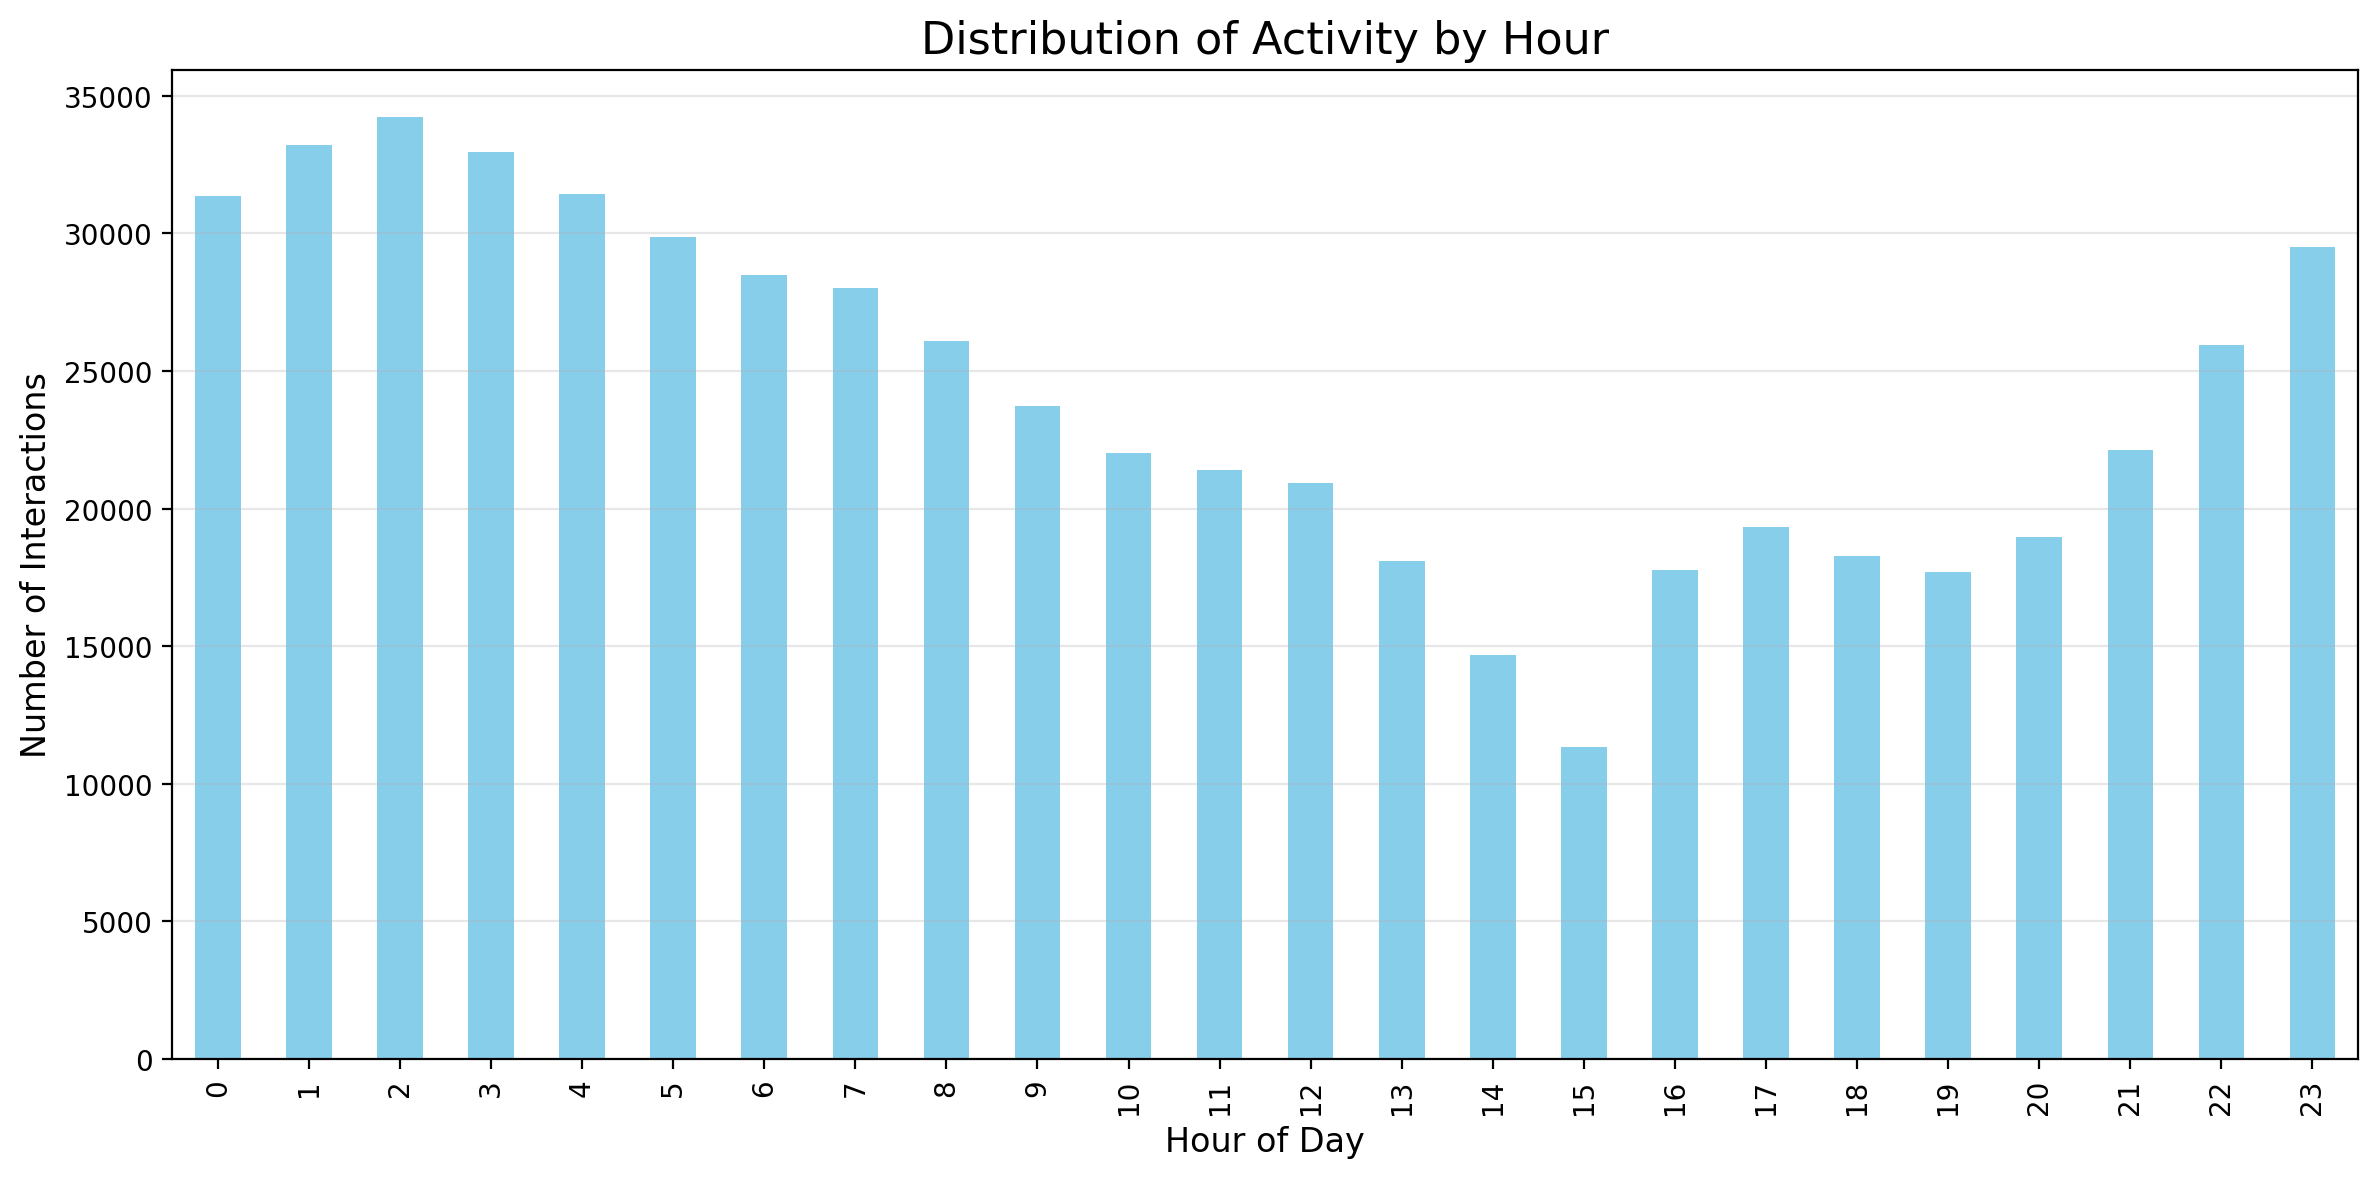

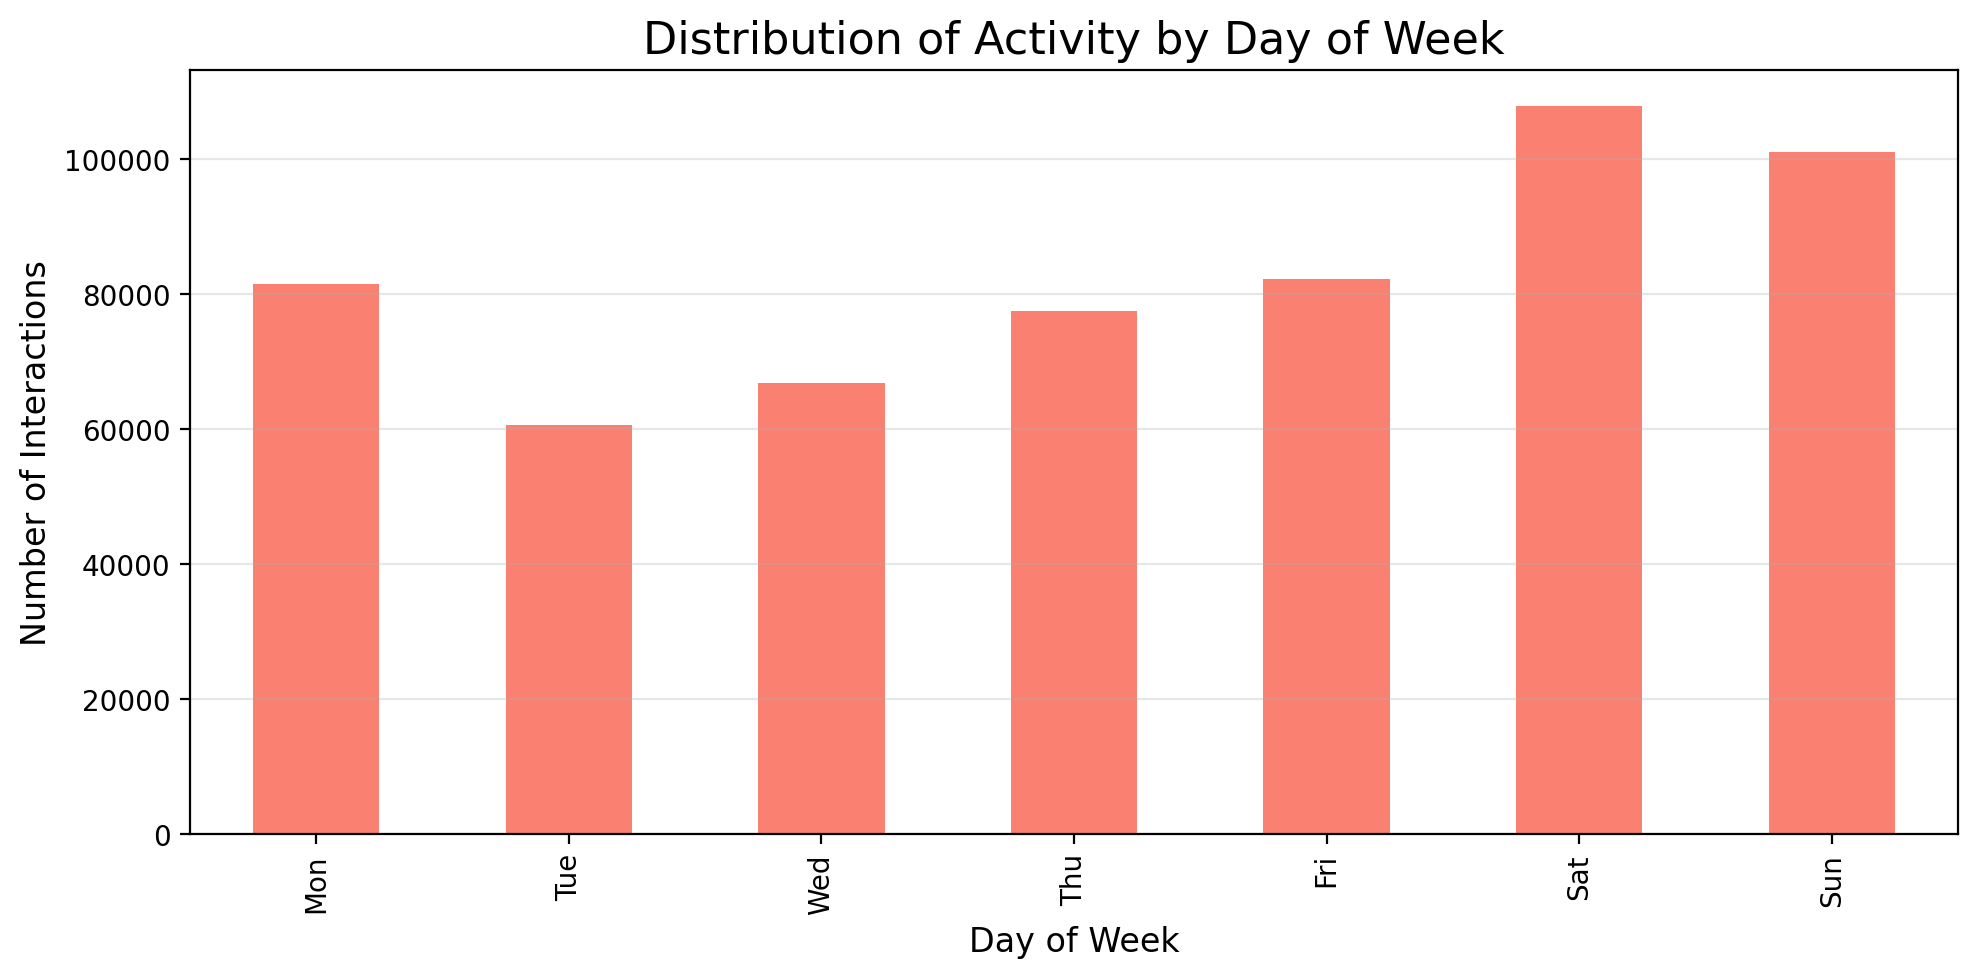

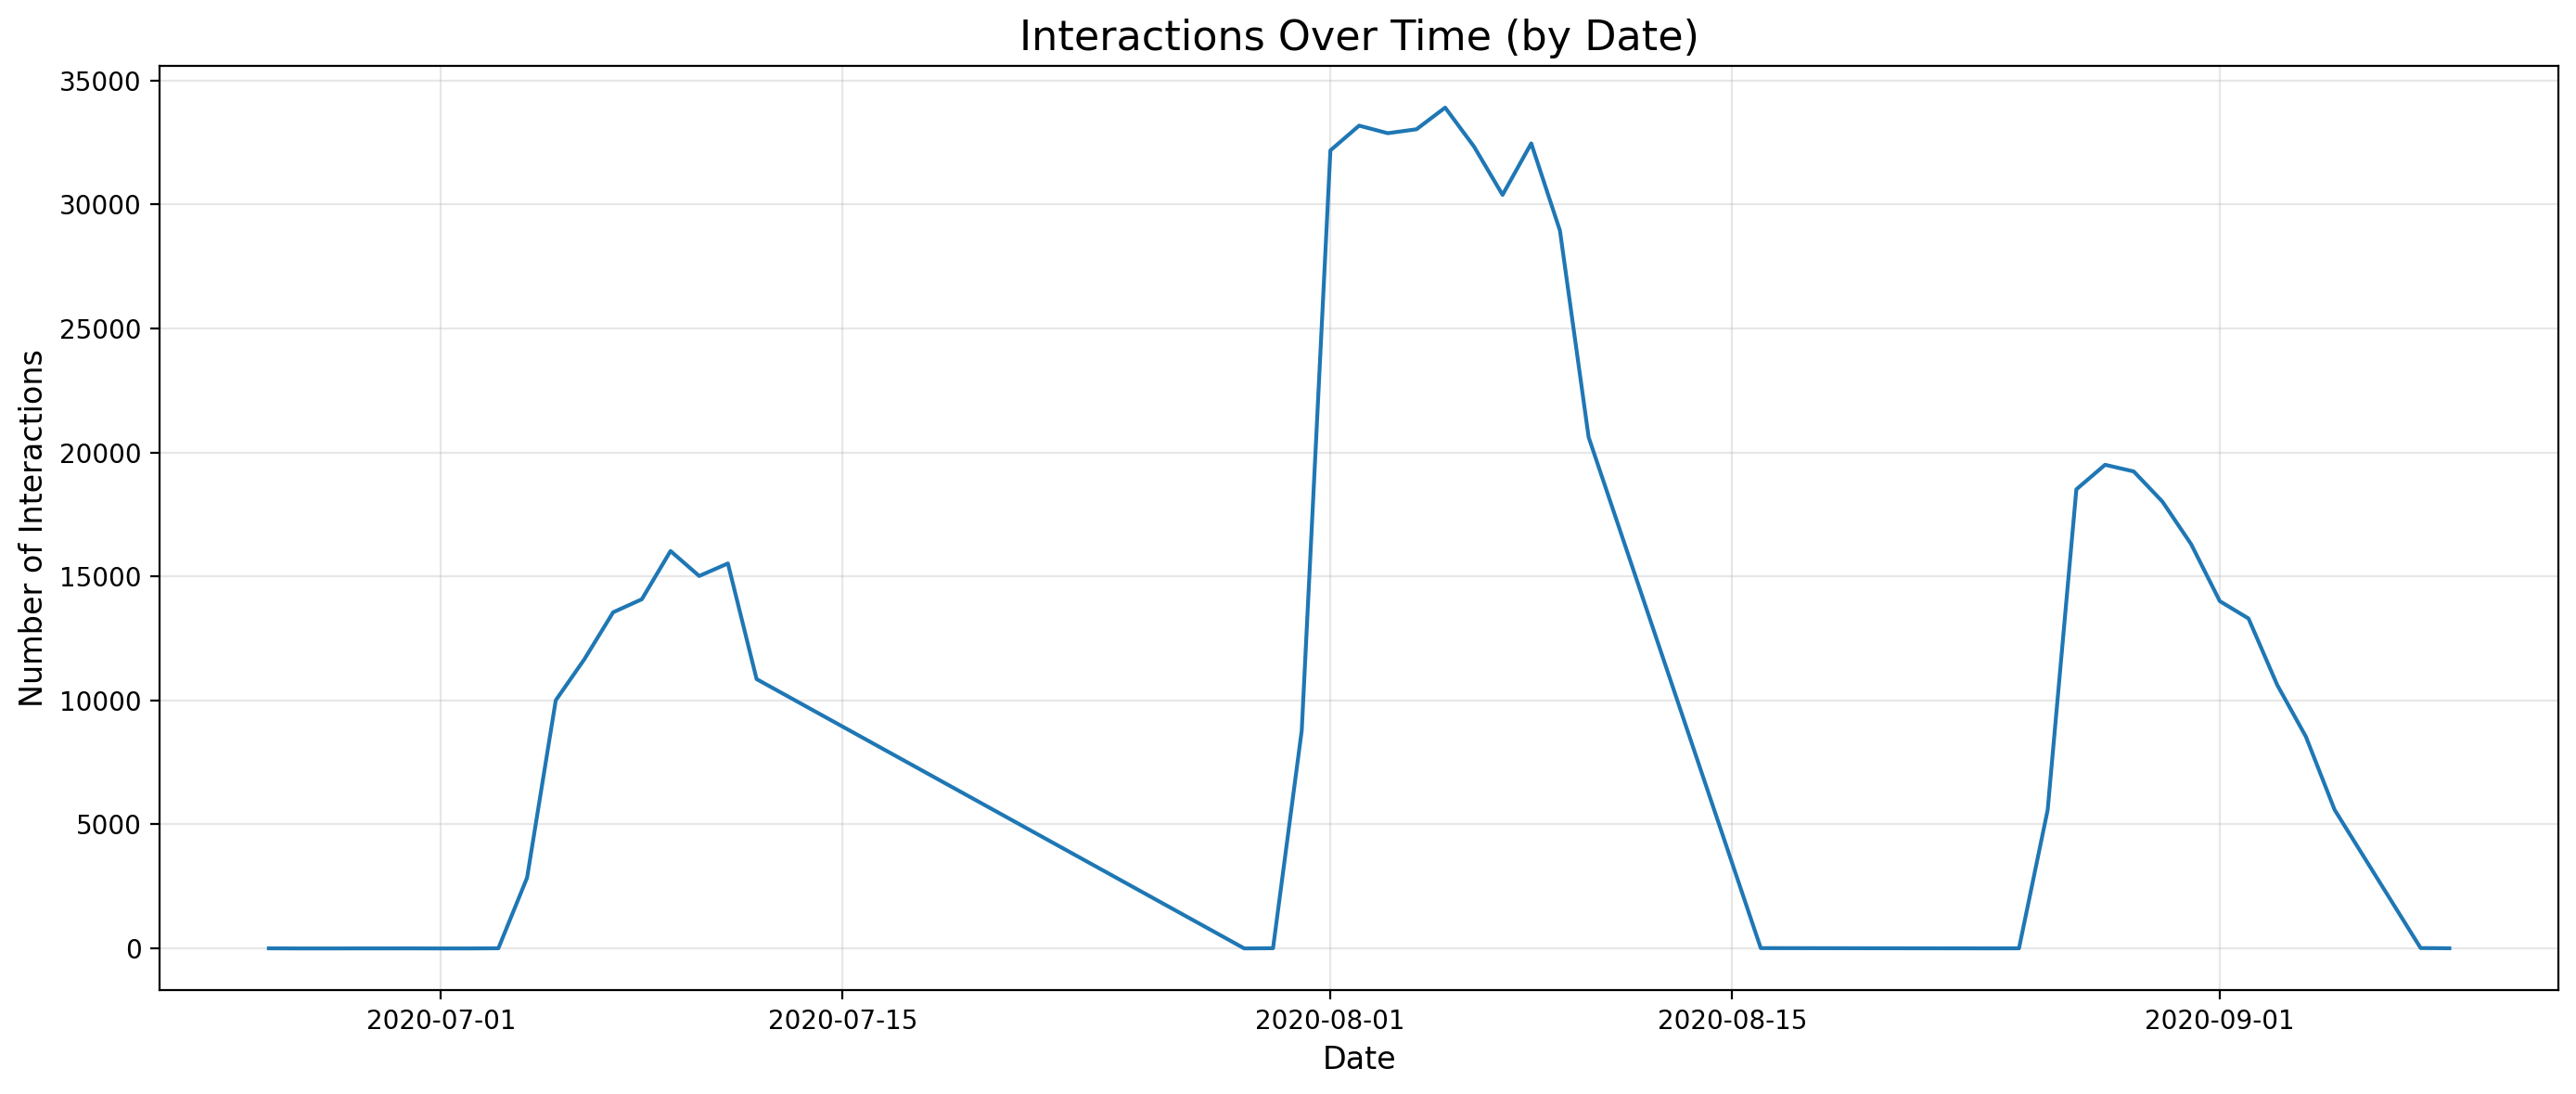

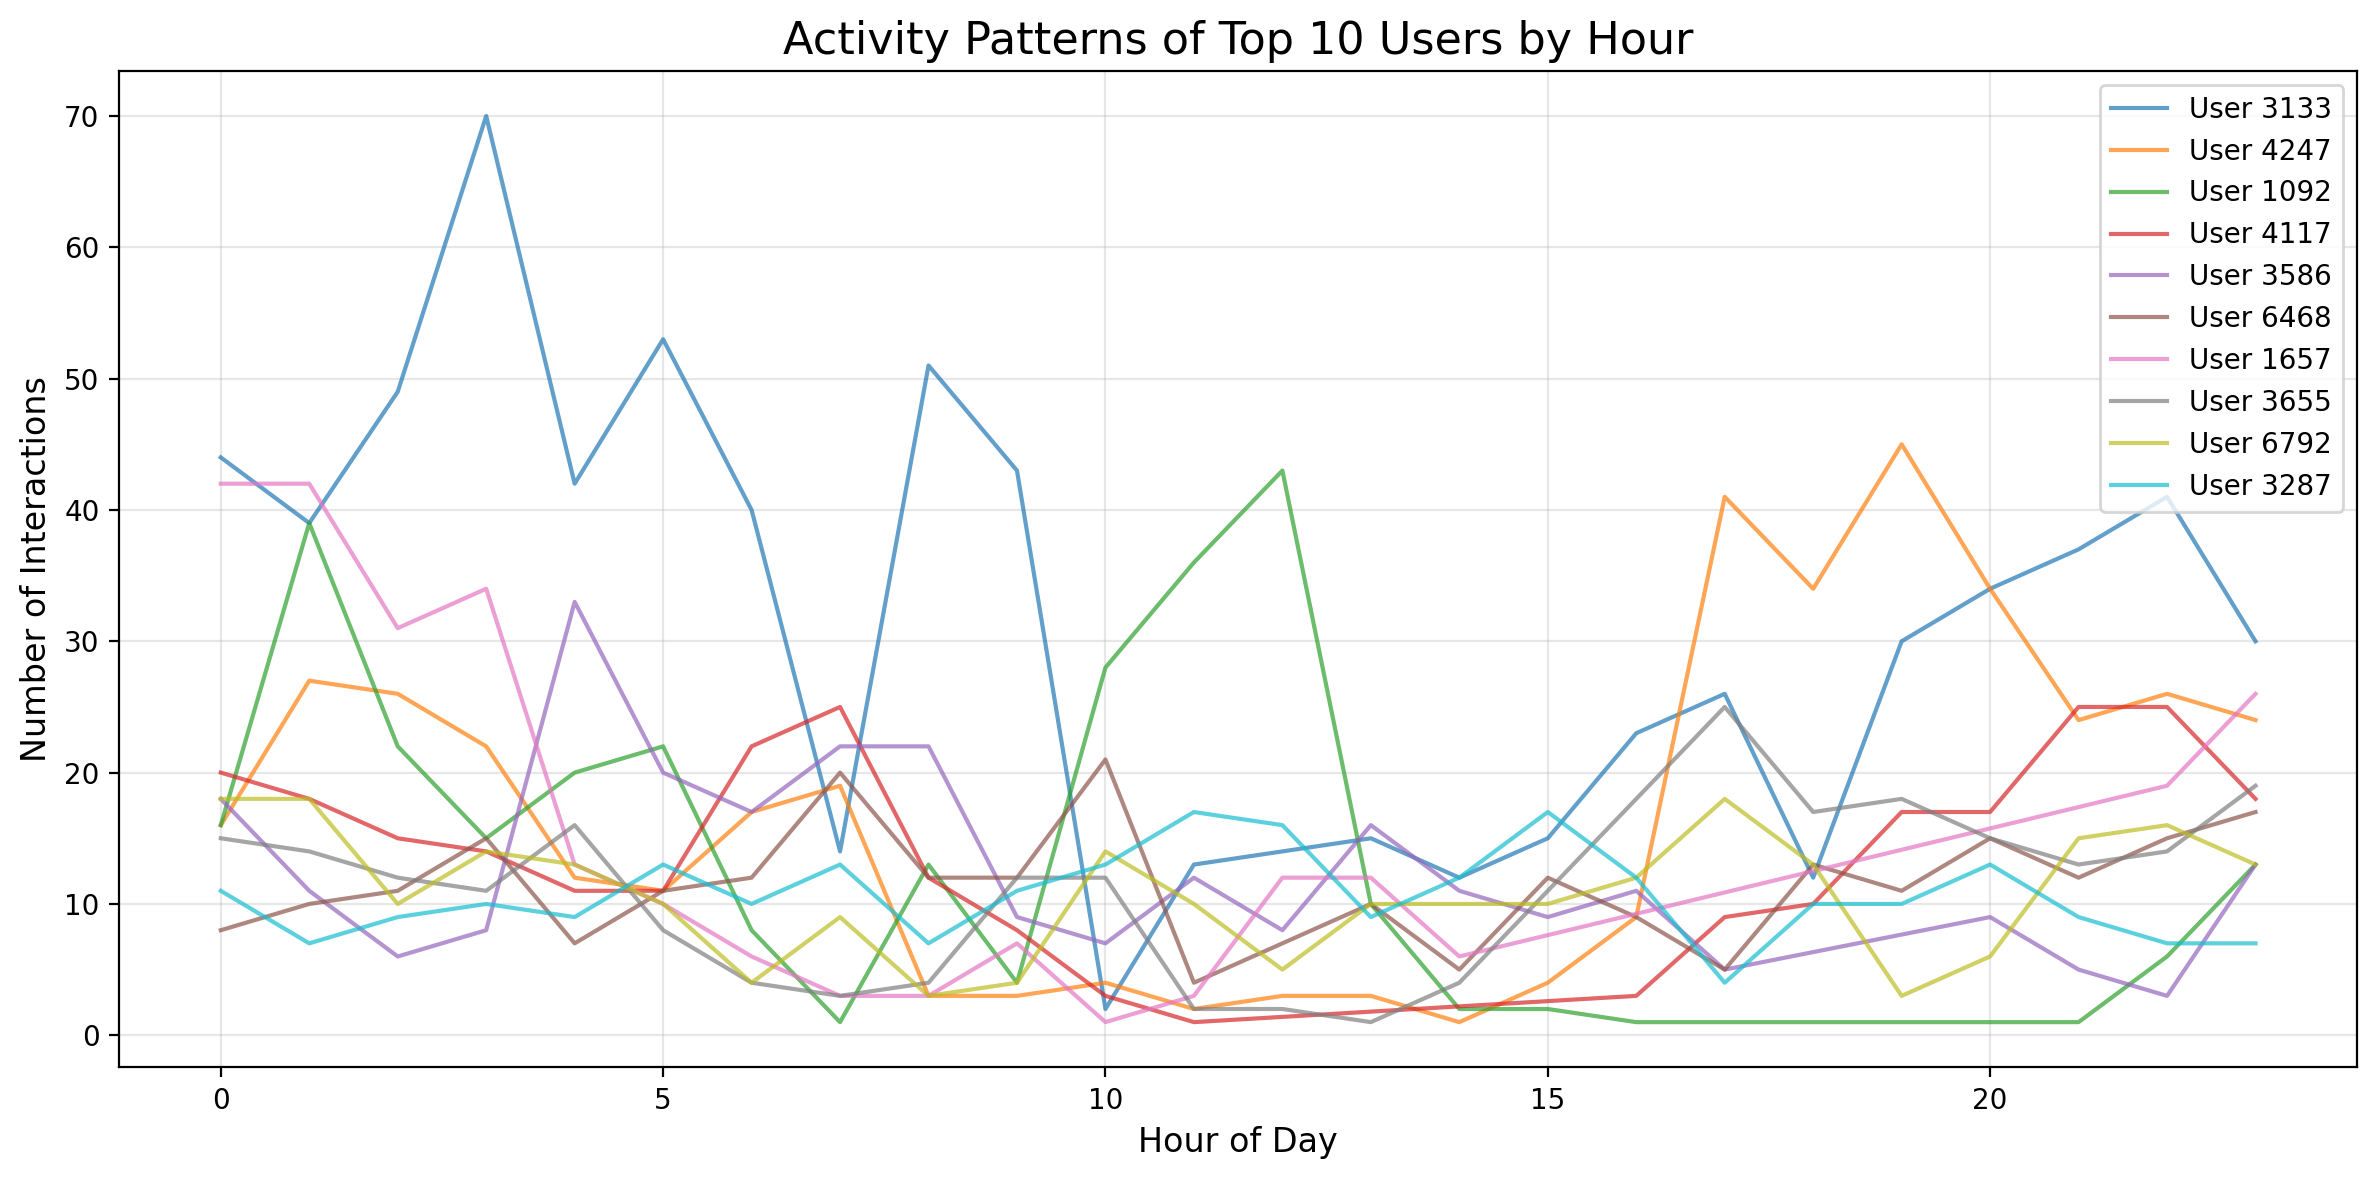


Peak Usage Hours:
Hour 2:00 - 34234 interactions
Hour 1:00 - 33202 interactions
Hour 3:00 - 32973 interactions

Peak Usage Days:
Saturday - 107826 interactions
Sunday - 101006 interactions
Friday - 82229 interactions


In [7]:
# Ensure all time columns are parsed correctly
big_matrix_pd["timestamp"] = pd.to_datetime(big_matrix_pd["timestamp"], errors="coerce", unit="s")
big_matrix_pd["date"] = pd.to_datetime(big_matrix_pd["date"], errors="coerce")
big_matrix_pd["time"] = pd.to_datetime(big_matrix_pd["time"], errors="coerce").dt.time

# Extract useful time features
big_matrix_pd["hour"] = big_matrix_pd["timestamp"].dt.hour
big_matrix_pd["weekday"] = big_matrix_pd["timestamp"].dt.dayofweek
big_matrix_pd["day"] = big_matrix_pd["timestamp"].dt.date

# Plot: Interactions by hour of day
plt.figure(figsize=(12, 6))
big_matrix_pd["hour"].value_counts().sort_index().plot(kind="bar", color="skyblue")
plt.title("Distribution of Activity by Hour", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Number of Interactions", fontsize=12)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Plot: Interactions by day of week
plt.figure(figsize=(10, 5))
weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
big_matrix_pd["weekday"].value_counts().sort_index().plot(kind="bar", color="salmon")
plt.title("Distribution of Activity by Day of Week", fontsize=16)
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Number of Interactions", fontsize=12)
plt.xticks(ticks=range(7), labels=weekday_labels)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Plot: Interactions over time (by date)
plt.figure(figsize=(14, 6))
big_matrix_pd["day"].value_counts().sort_index().plot()
plt.title("Interactions Over Time (by Date)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Interactions", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot: Activity patterns for top 10 users by hour
top_users = big_matrix_pd["user_id"].value_counts().head(10).index
plt.figure(figsize=(12, 6))
for user in top_users:
    user_data = big_matrix_pd[big_matrix_pd["user_id"] == user]
    user_data["hour"].value_counts().sort_index().plot(
        kind="line", alpha=0.7, label=f"User {user}"
    )
plt.title("Activity Patterns of Top 10 Users by Hour", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Number of Interactions", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Find and print peak usage times
hourly_activity = big_matrix_pd["hour"].value_counts().sort_index()
peak_hours = hourly_activity.nlargest(3)
print("\nPeak Usage Hours:")
for hour, count in peak_hours.items():
    print(f"Hour {hour}:00 - {count} interactions")

weekday_activity = big_matrix_pd["weekday"].value_counts().sort_index()
peak_days = weekday_activity.nlargest(3)
weekday_labels_full = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
print("\nPeak Usage Days:")
for day, count in peak_days.items():
    print(f"{weekday_labels_full[day]} - {count} interactions")

##

In [ ]:
df_small_matrix.show(5)
print(f"Shape of the small matrix: {df_small_matrix.count()} rows, {len(df_small_matrix.columns)} columns")
unique_users = df_small_matrix.select("user_id").distinct().count()
unique_posts = df_small_matrix.select("video_id").distinct().count()
print(f"Unique users: {unique_users}")
print(f"Unique posts: {unique_posts}")
print(f"Matrix sparsity: {df_small_matrix.count() / (unique_posts * unique_users) * 100}%")

+-------+--------+-------------+--------------+--------------------+-----------+----------------+------------------+
|user_id|video_id|play_duration|video_duration|                time|       date|       timestamp|       watch_ratio|
+-------+--------+-------------+--------------+--------------------+-----------+----------------+------------------+
|     14|    2201|         8554|          7339|2020-07-11 08:20:...|2.0200711E7|1.594426827368E9|1.1655538901757732|
|     14|    5537|         8474|         11434|2020-07-17 01:42:...|2.0200717E7|1.594921322105E9|0.7411229665908693|
|     14|    7155|         4456|          8567|2020-07-20 21:59:...| 2.020072E7|1.595253554602E9|0.5201354032917007|
|     14|    7029|        11601|         10867|2020-07-25 21:36:...|2.0200725E7|1.595684186901E9|1.0675439403699274|
|     14|    2039|        11519|          6520|2020-07-25 23:24:...|2.0200725E7|1.595690664559E9| 1.766717791411043|
+-------+--------+-------------+--------------+-----------------

Shape of the small matrix: 4494578 rows, 8 columns


Unique users: 1411
Unique posts: 3327


Matrix sparsity: 95.74345757293216%


: 

### Analysis of the Small Matrix Visualizations

#### 1. **Top 20 Most Popular Videos**
- The most popular videos in the small matrix are watched by around 90–100 unique users each.
- The popularity is much lower than in the big matrix, reflecting the smaller size and higher sparsity of this dataset.

#### 2. **Bottom 20 Least Popular Videos**
- The least popular videos are watched by about 35–46 unique users.
- There are no videos with only a single viewer, but the distribution is still skewed, with many videos having relatively few viewers.

#### 3. **Top 20 Most Active Users**
- The most active users have around 190–200 interactions.
- This is much lower than the most active users in the big matrix, again due to the smaller dataset.

#### 4. **Bottom 20 Least Active Users**
- The least active users have about 125–135 interactions.
- Even the least active users in this sample are more active than the least active users in the big matrix, likely due to filtering or the way the sample was constructed.

---

### Relevance for Testing a Recommendation Model

- **User interactions:**  
  All users in the small matrix have a high number of interactions. This ensures that every user has a substantial interaction history, making it possible to evaluate the recommender system's ability to provide relevant recommendations for active users.

- **No Data Leakage:**  
  Since the small matrix is separate from the training data, it provides an unbiased evaluation of model performance.

---

> **Note:** All visualizations are based on a random 5% sample (`fraction=0.05`) of the small matrix for efficiency and clarity. The full dataset is used for model evaluation.

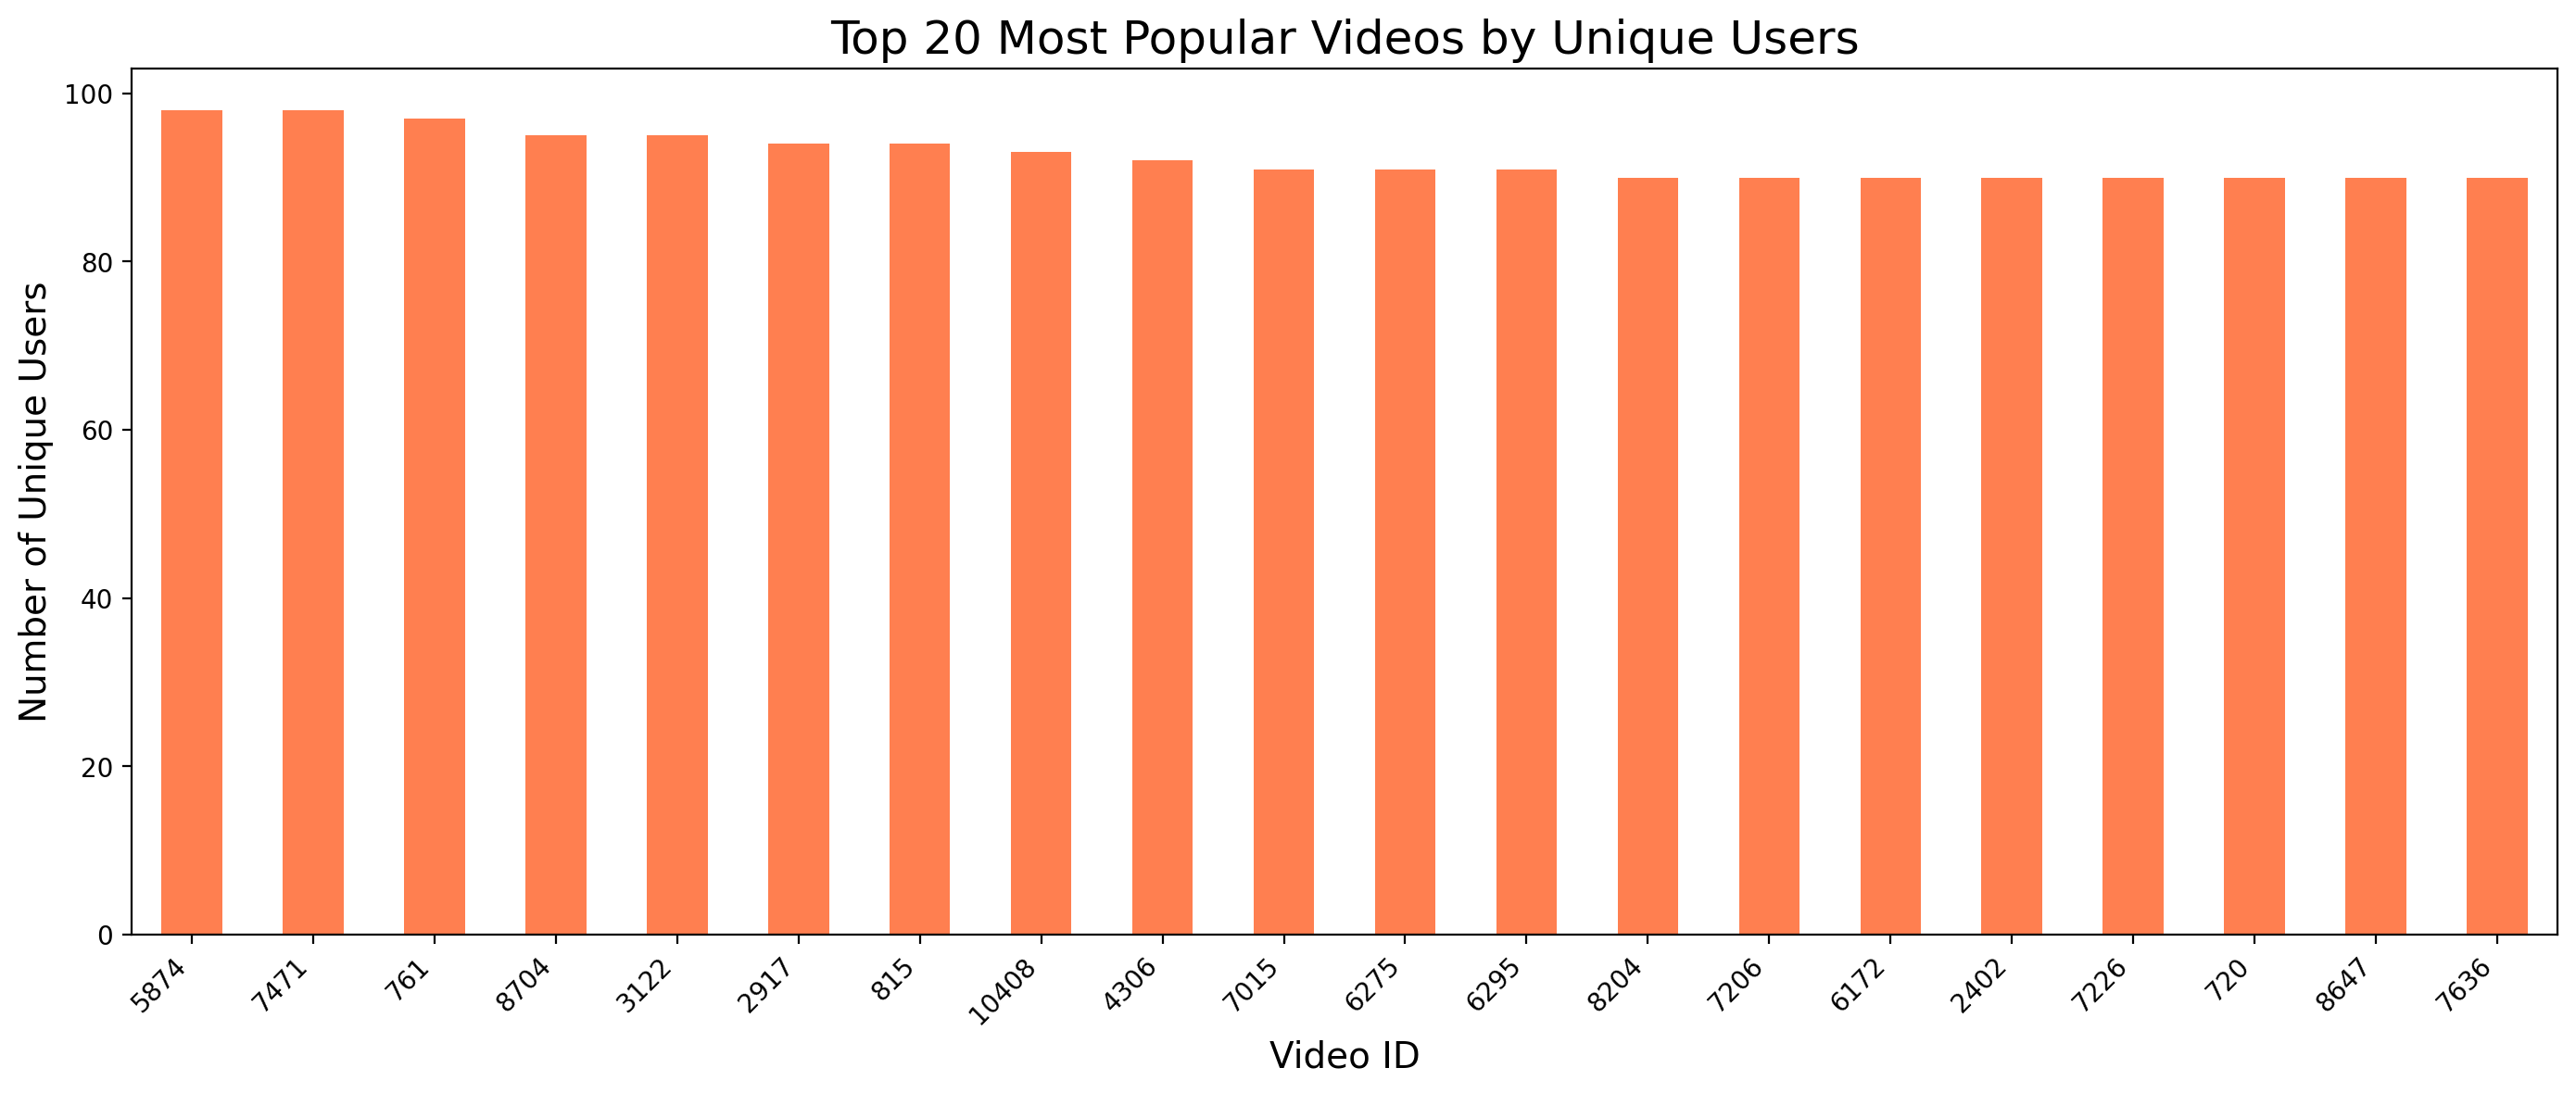

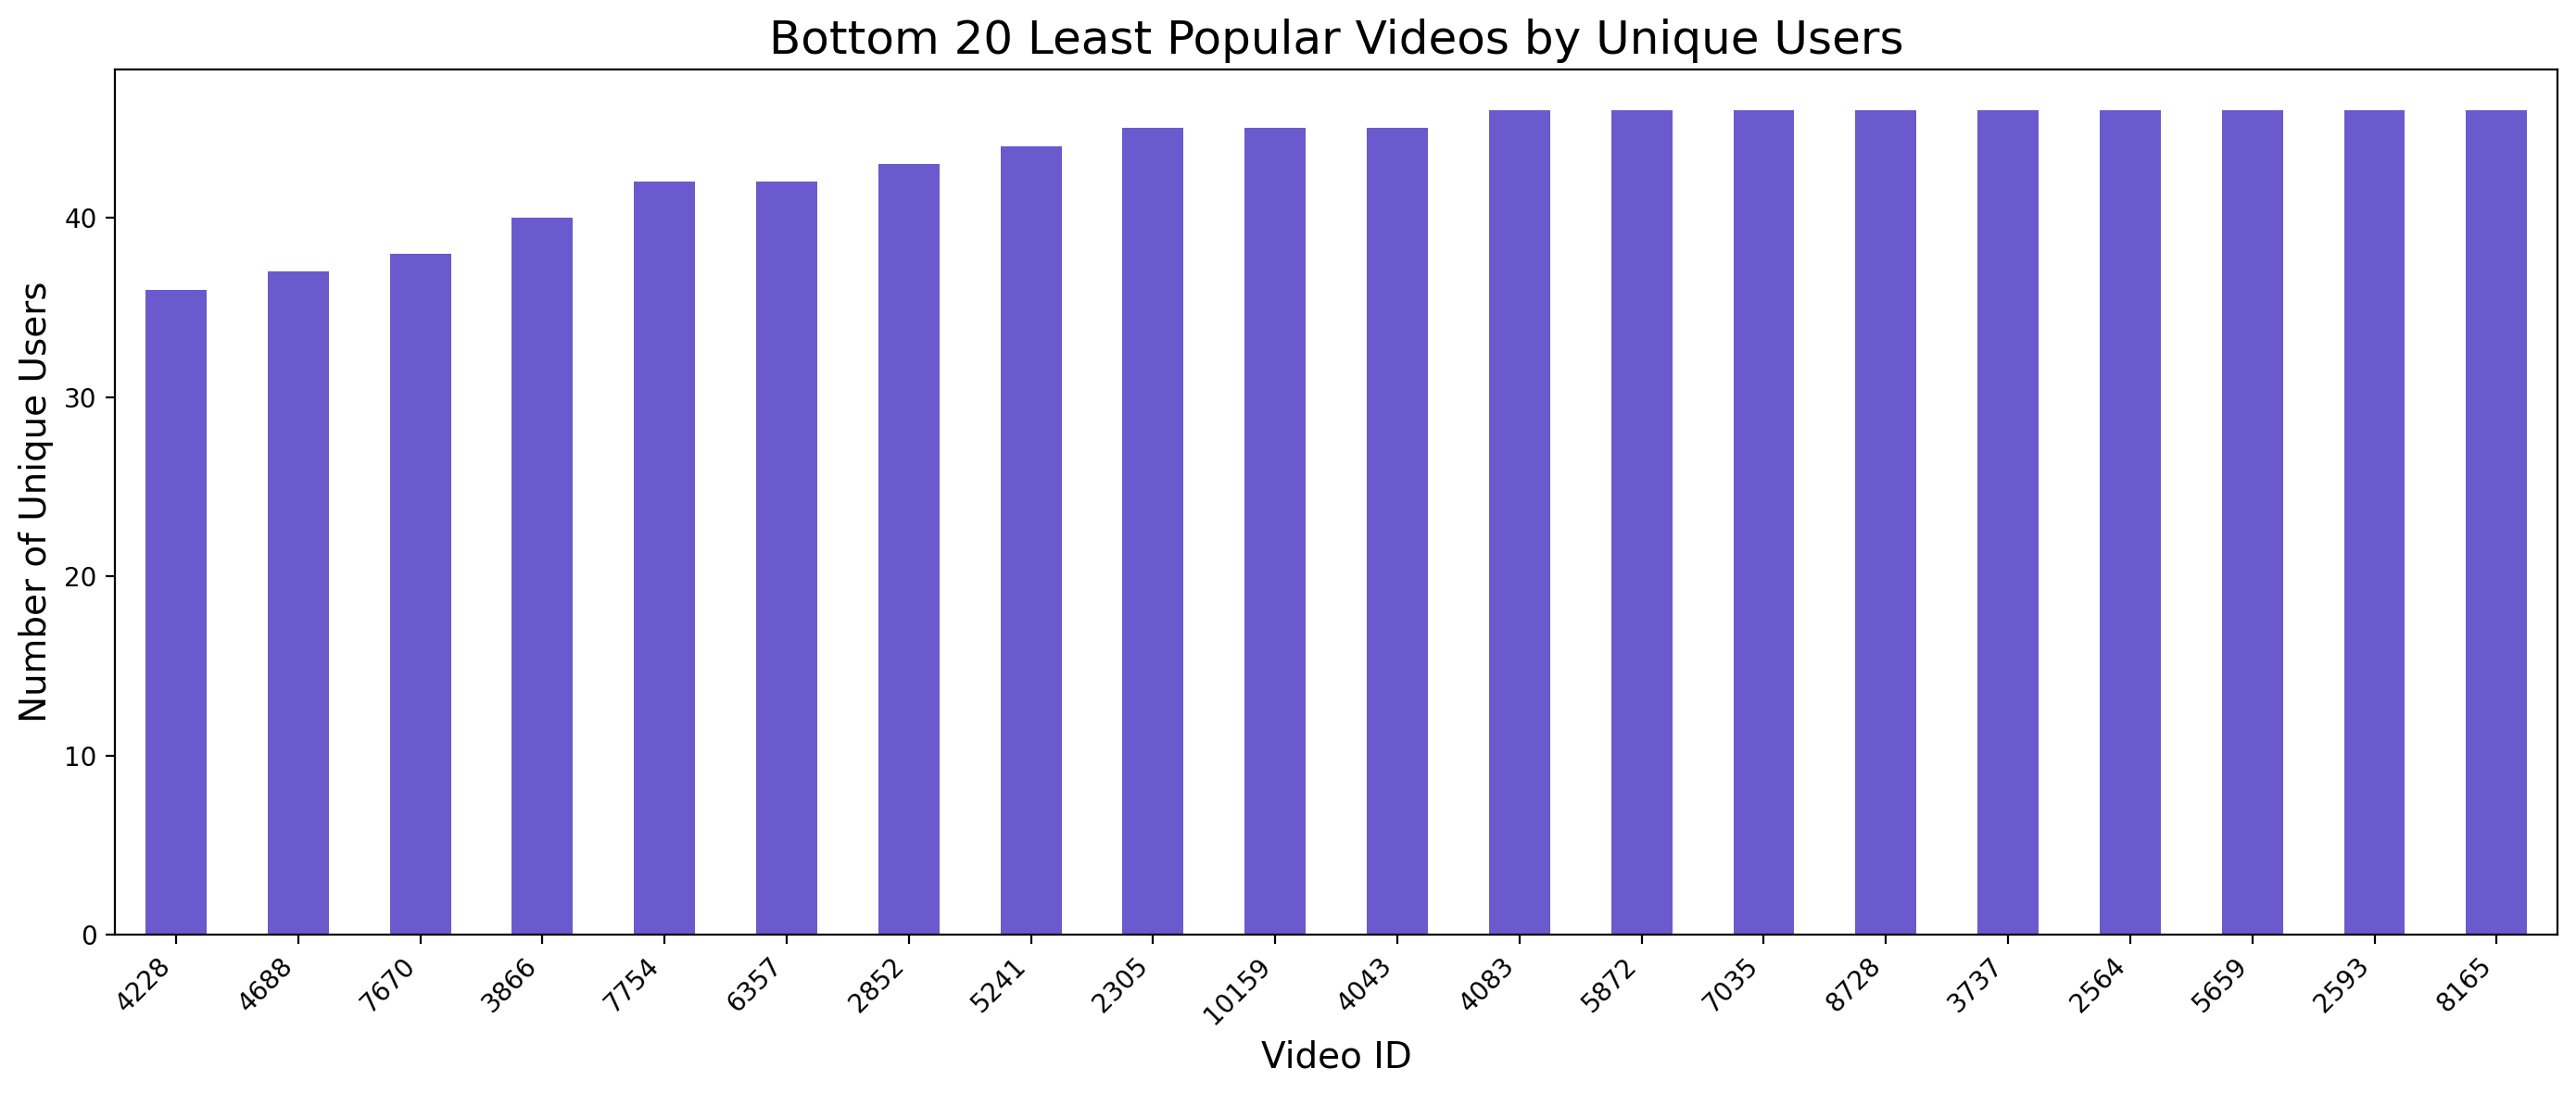

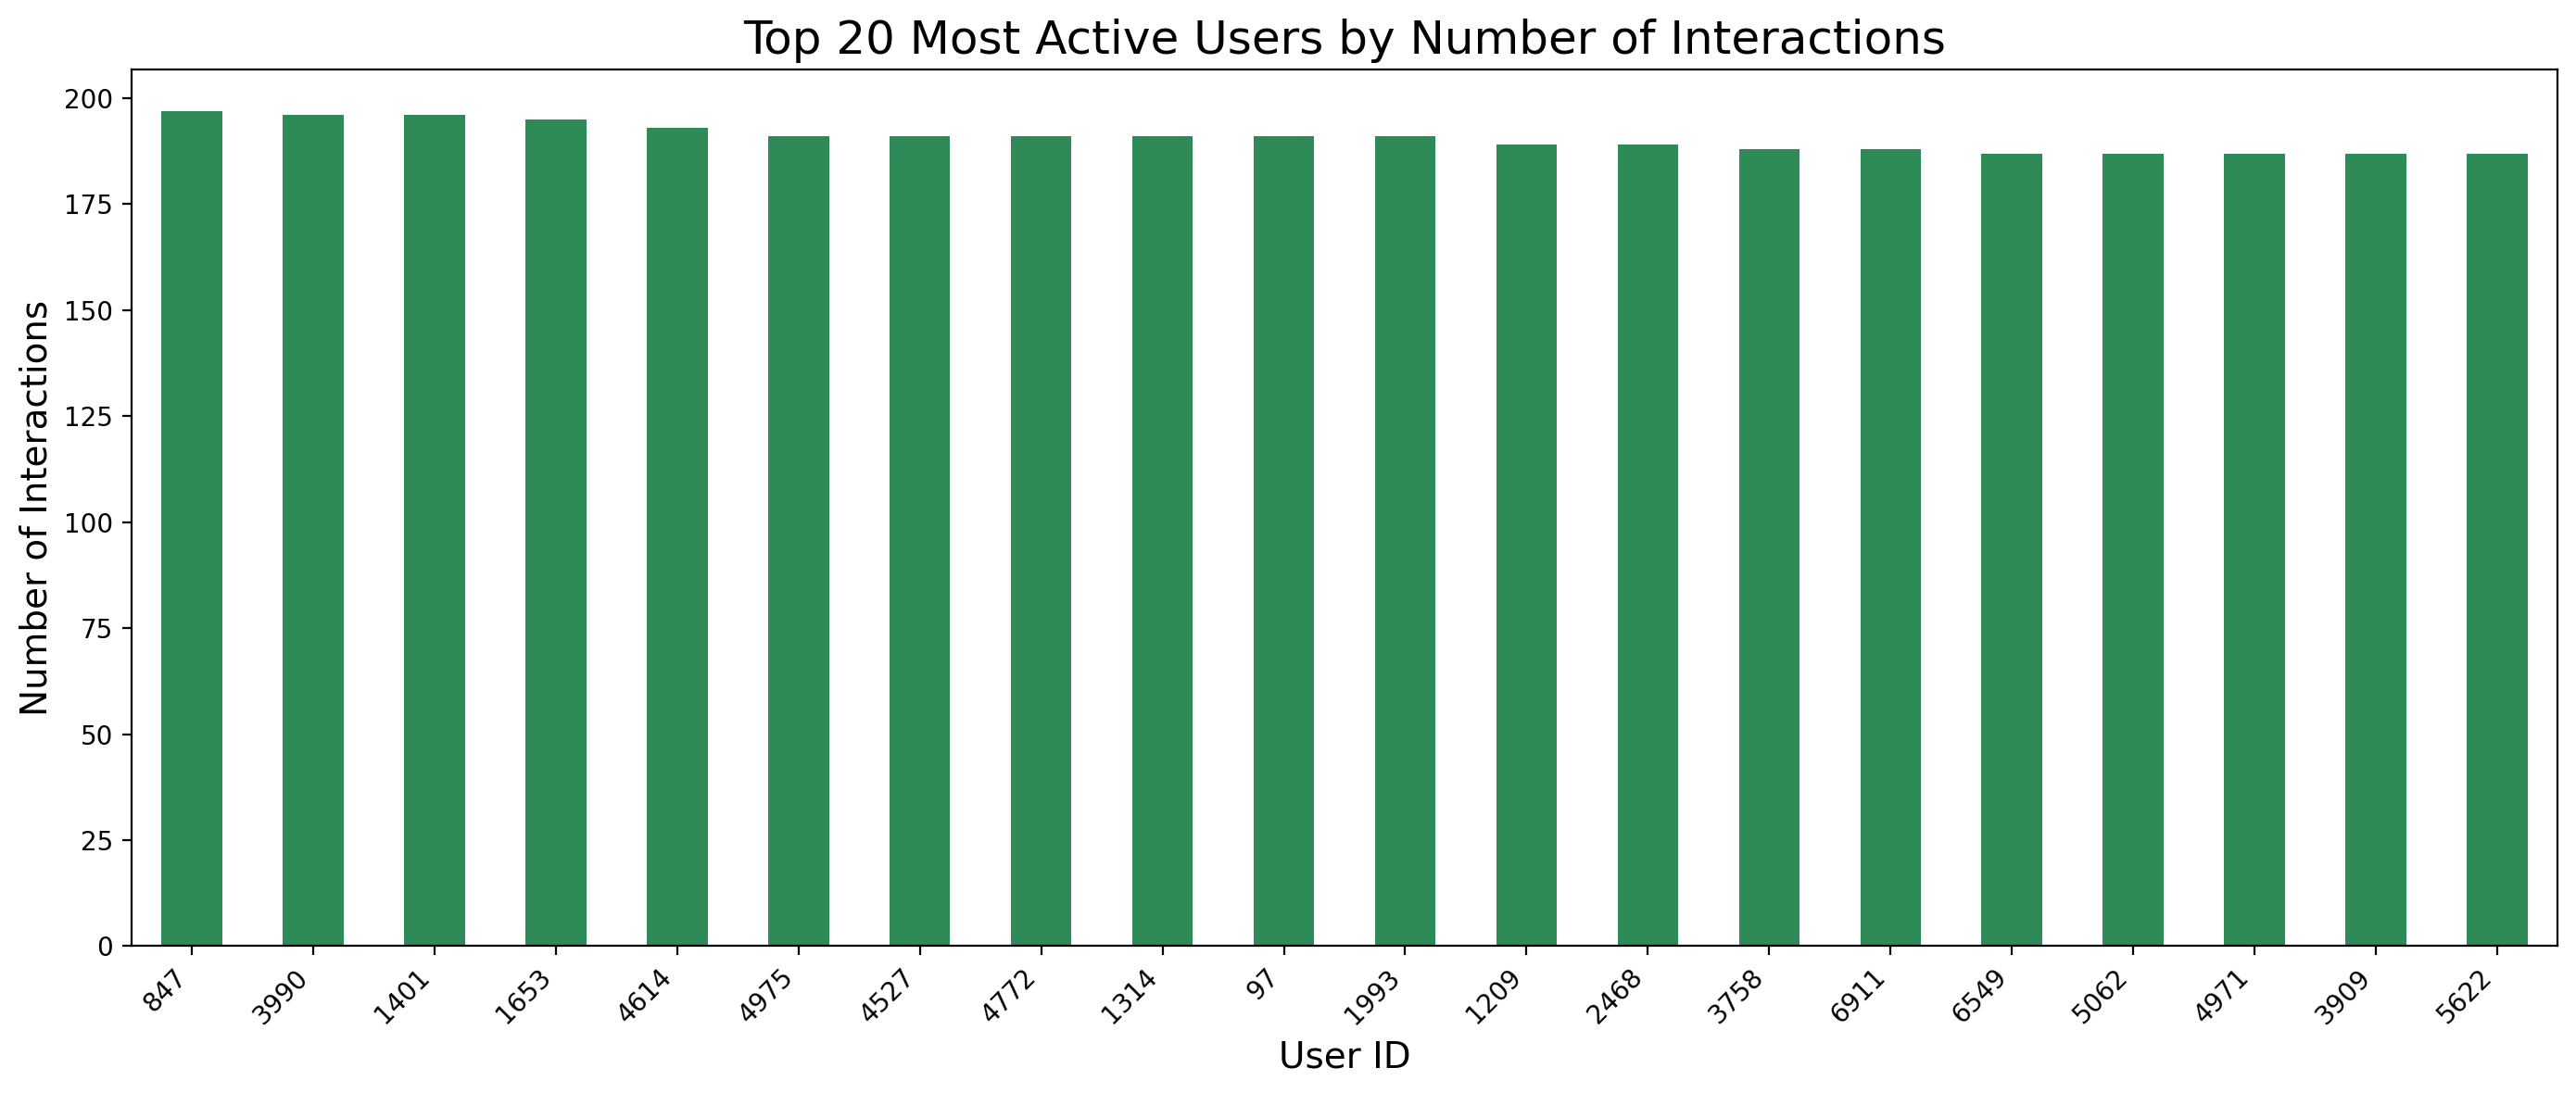

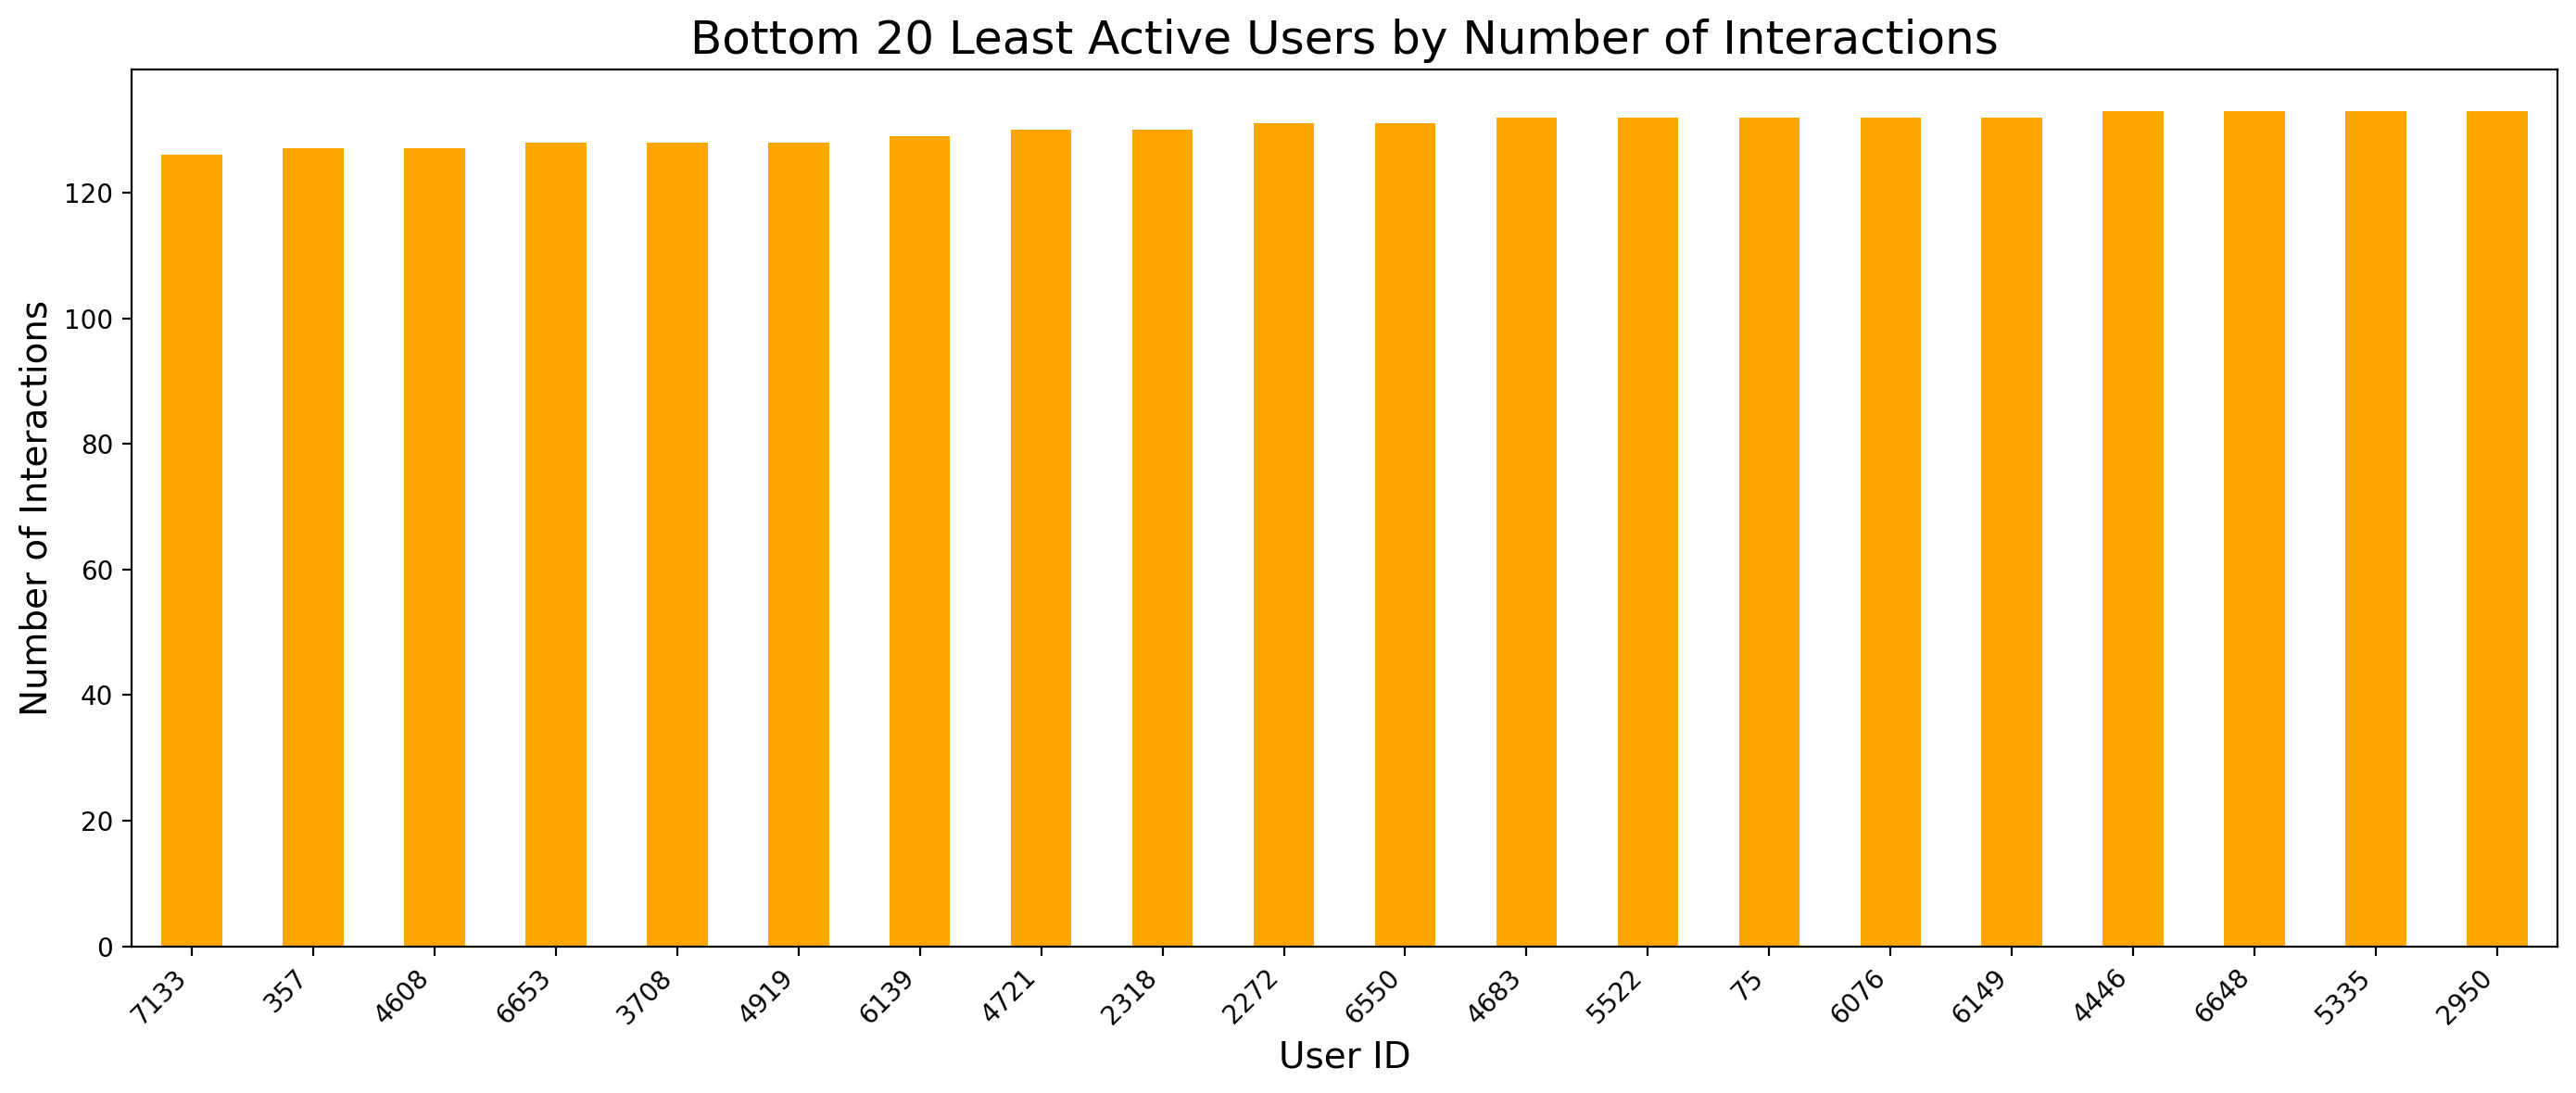

In [52]:
#Sample a manageable amount of data for visualization
small_matrix_pd = df_small_matrix.sample(fraction=0.05, seed=42).toPandas()

# Plot top 20 most popular videos by number of unique users
top_videos = (
    small_matrix_pd.groupby('video_id')['user_id']
    .nunique()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(14, 6))
top_videos.plot(kind='bar', color='coral')
plt.title('Top 20 Most Popular Videos by Unique Users', fontsize=18)
plt.xlabel('Video ID', fontsize=14)
plt.ylabel('Number of Unique Users', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

worst_videos = (
    small_matrix_pd.groupby('video_id')['user_id']
    .nunique()
    .sort_values(ascending=True)
    .head(20)
)

plt.figure(figsize=(14, 6))
worst_videos.plot(kind='bar', color='slateblue')
plt.title('Bottom 20 Least Popular Videos by Unique Users', fontsize=18)
plt.xlabel('Video ID', fontsize=14)
plt.ylabel('Number of Unique Users', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot number of interactions per user (top 20)
top_users = (
    small_matrix_pd.groupby('user_id')['video_id']
    .count()
    .sort_values(ascending=False)
    .head(20)
)

plt.figure(figsize=(14, 6))
top_users.plot(kind='bar', color='seagreen')
plt.title('Top 20 Most Active Users by Number of Interactions', fontsize=18)
plt.xlabel('User ID', fontsize=14)
plt.ylabel('Number of Interactions', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

worst_users = (
    small_matrix_pd.groupby('user_id')['video_id']
    .count()
    .sort_values(ascending=True)
    .head(20)
)

plt.figure(figsize=(14, 6))
worst_users.plot(kind='bar', color='orange')
plt.title('Bottom 20 Least Active Users by Number of Interactions', fontsize=18)
plt.xlabel('User ID', fontsize=14)
plt.ylabel('Number of Interactions', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The small matrix represents a subset of highly active users with consistent engagement, while the big matrix captures the full diversity of user behavior, including inactivity and data gaps. This distinction is important for training (big matrix) versus testing (small matrix) recommender systems.

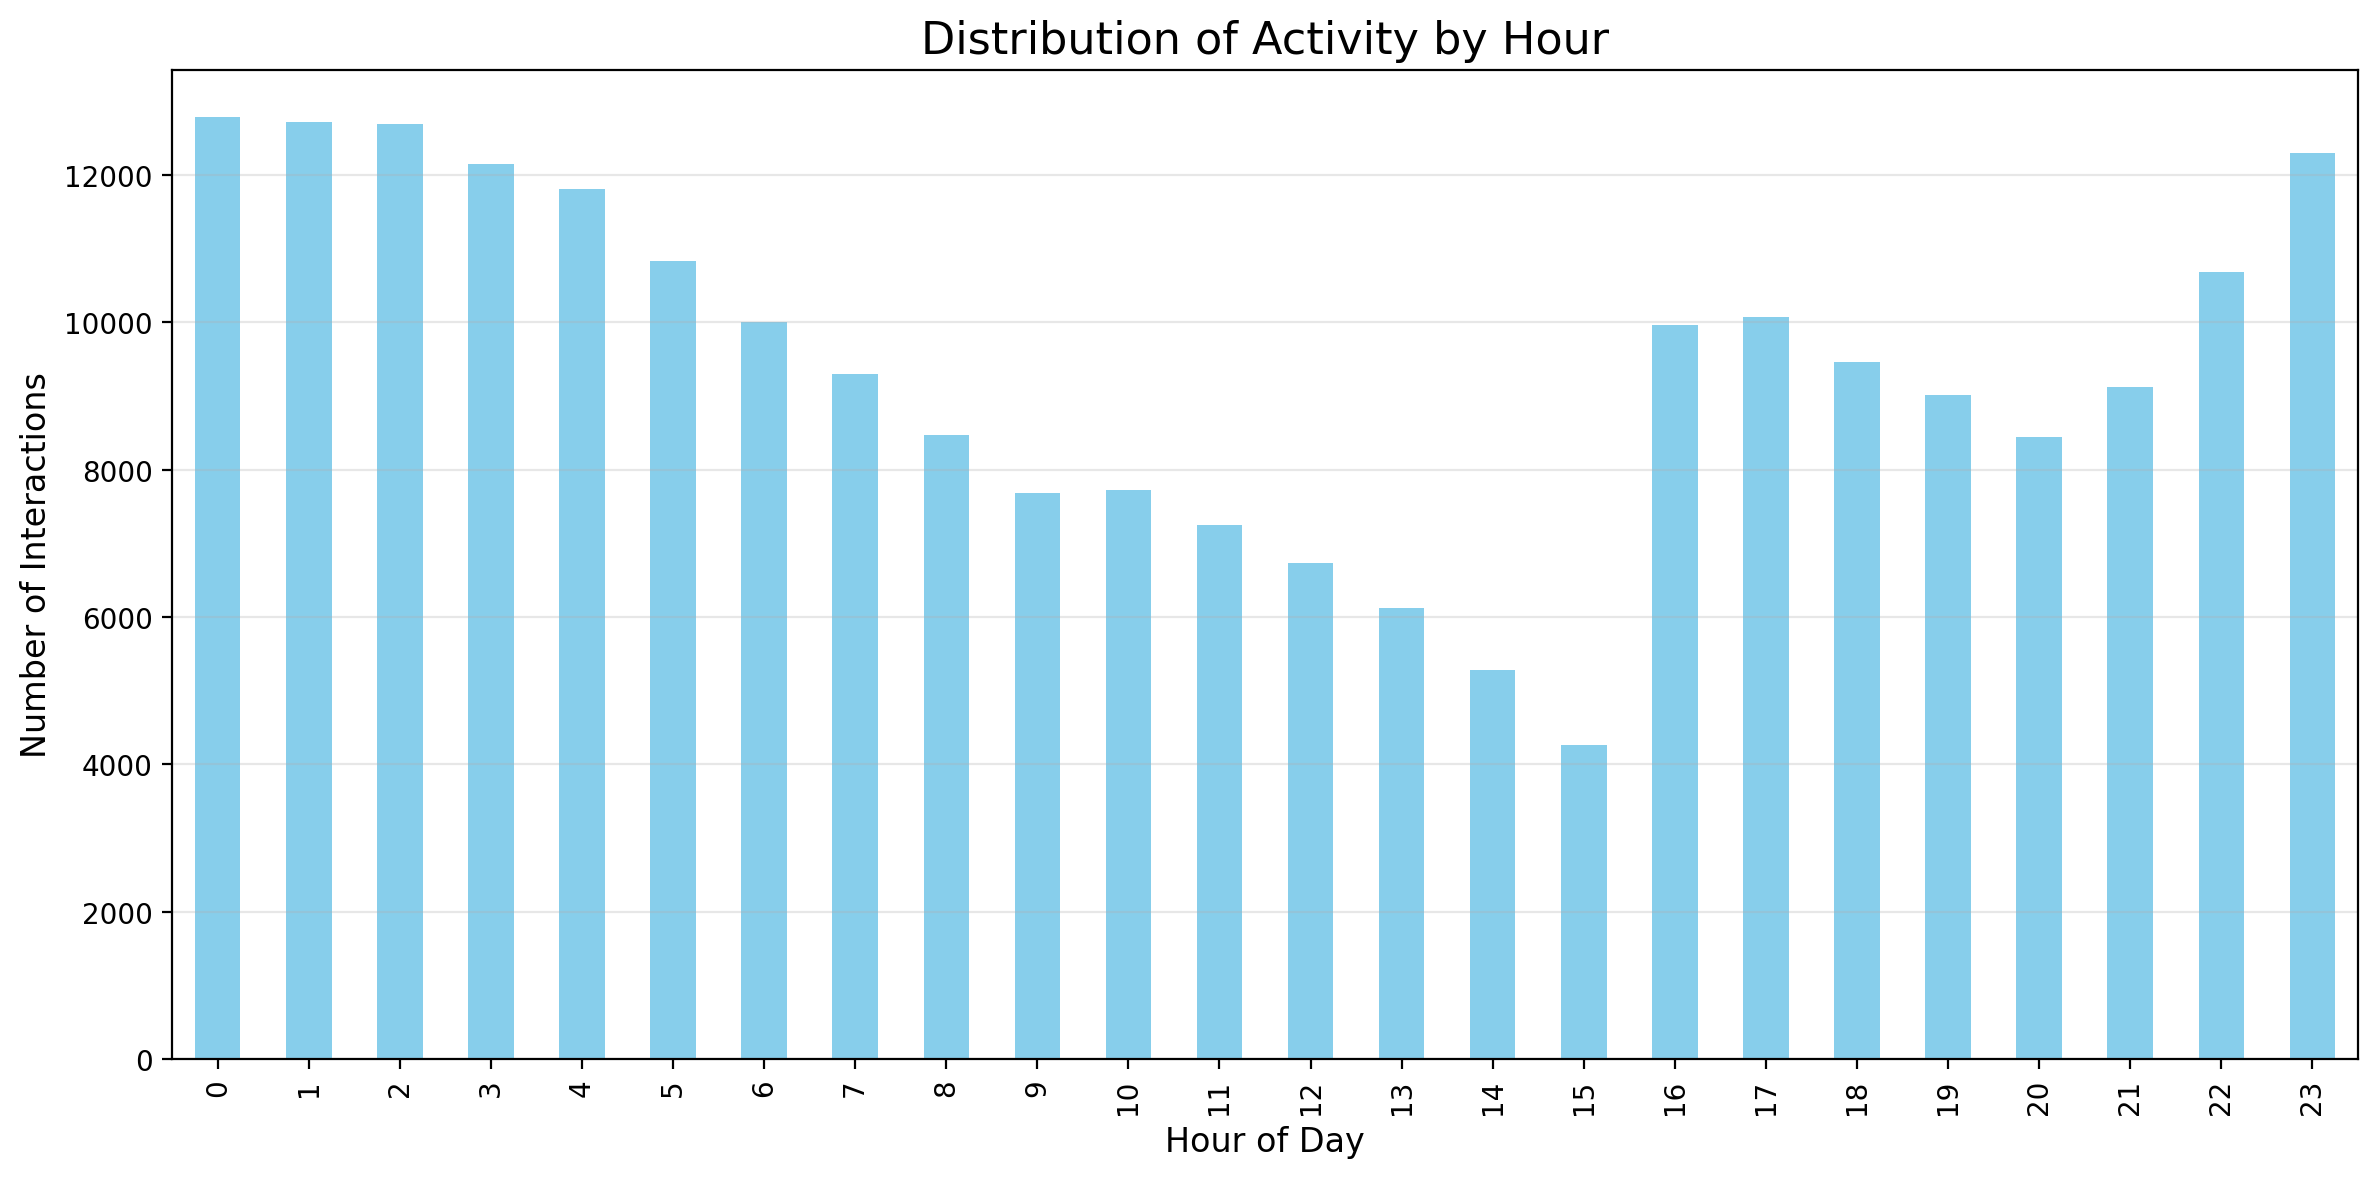

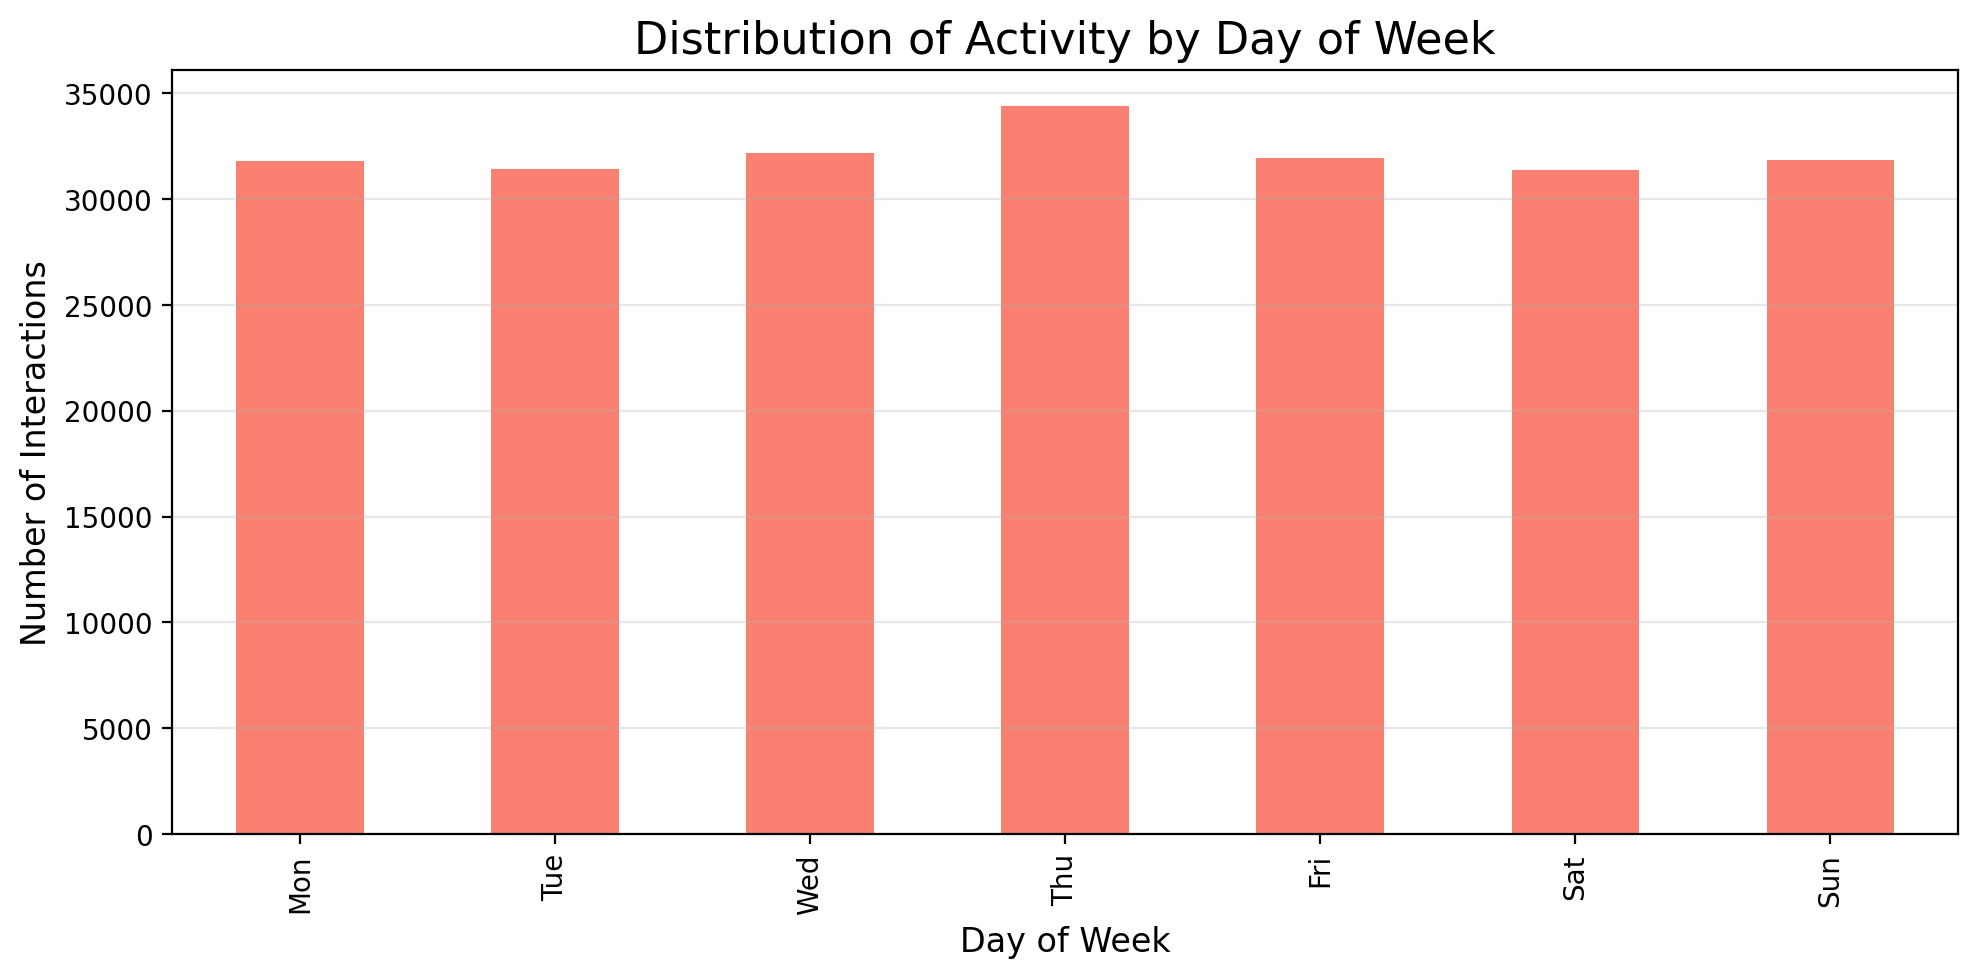

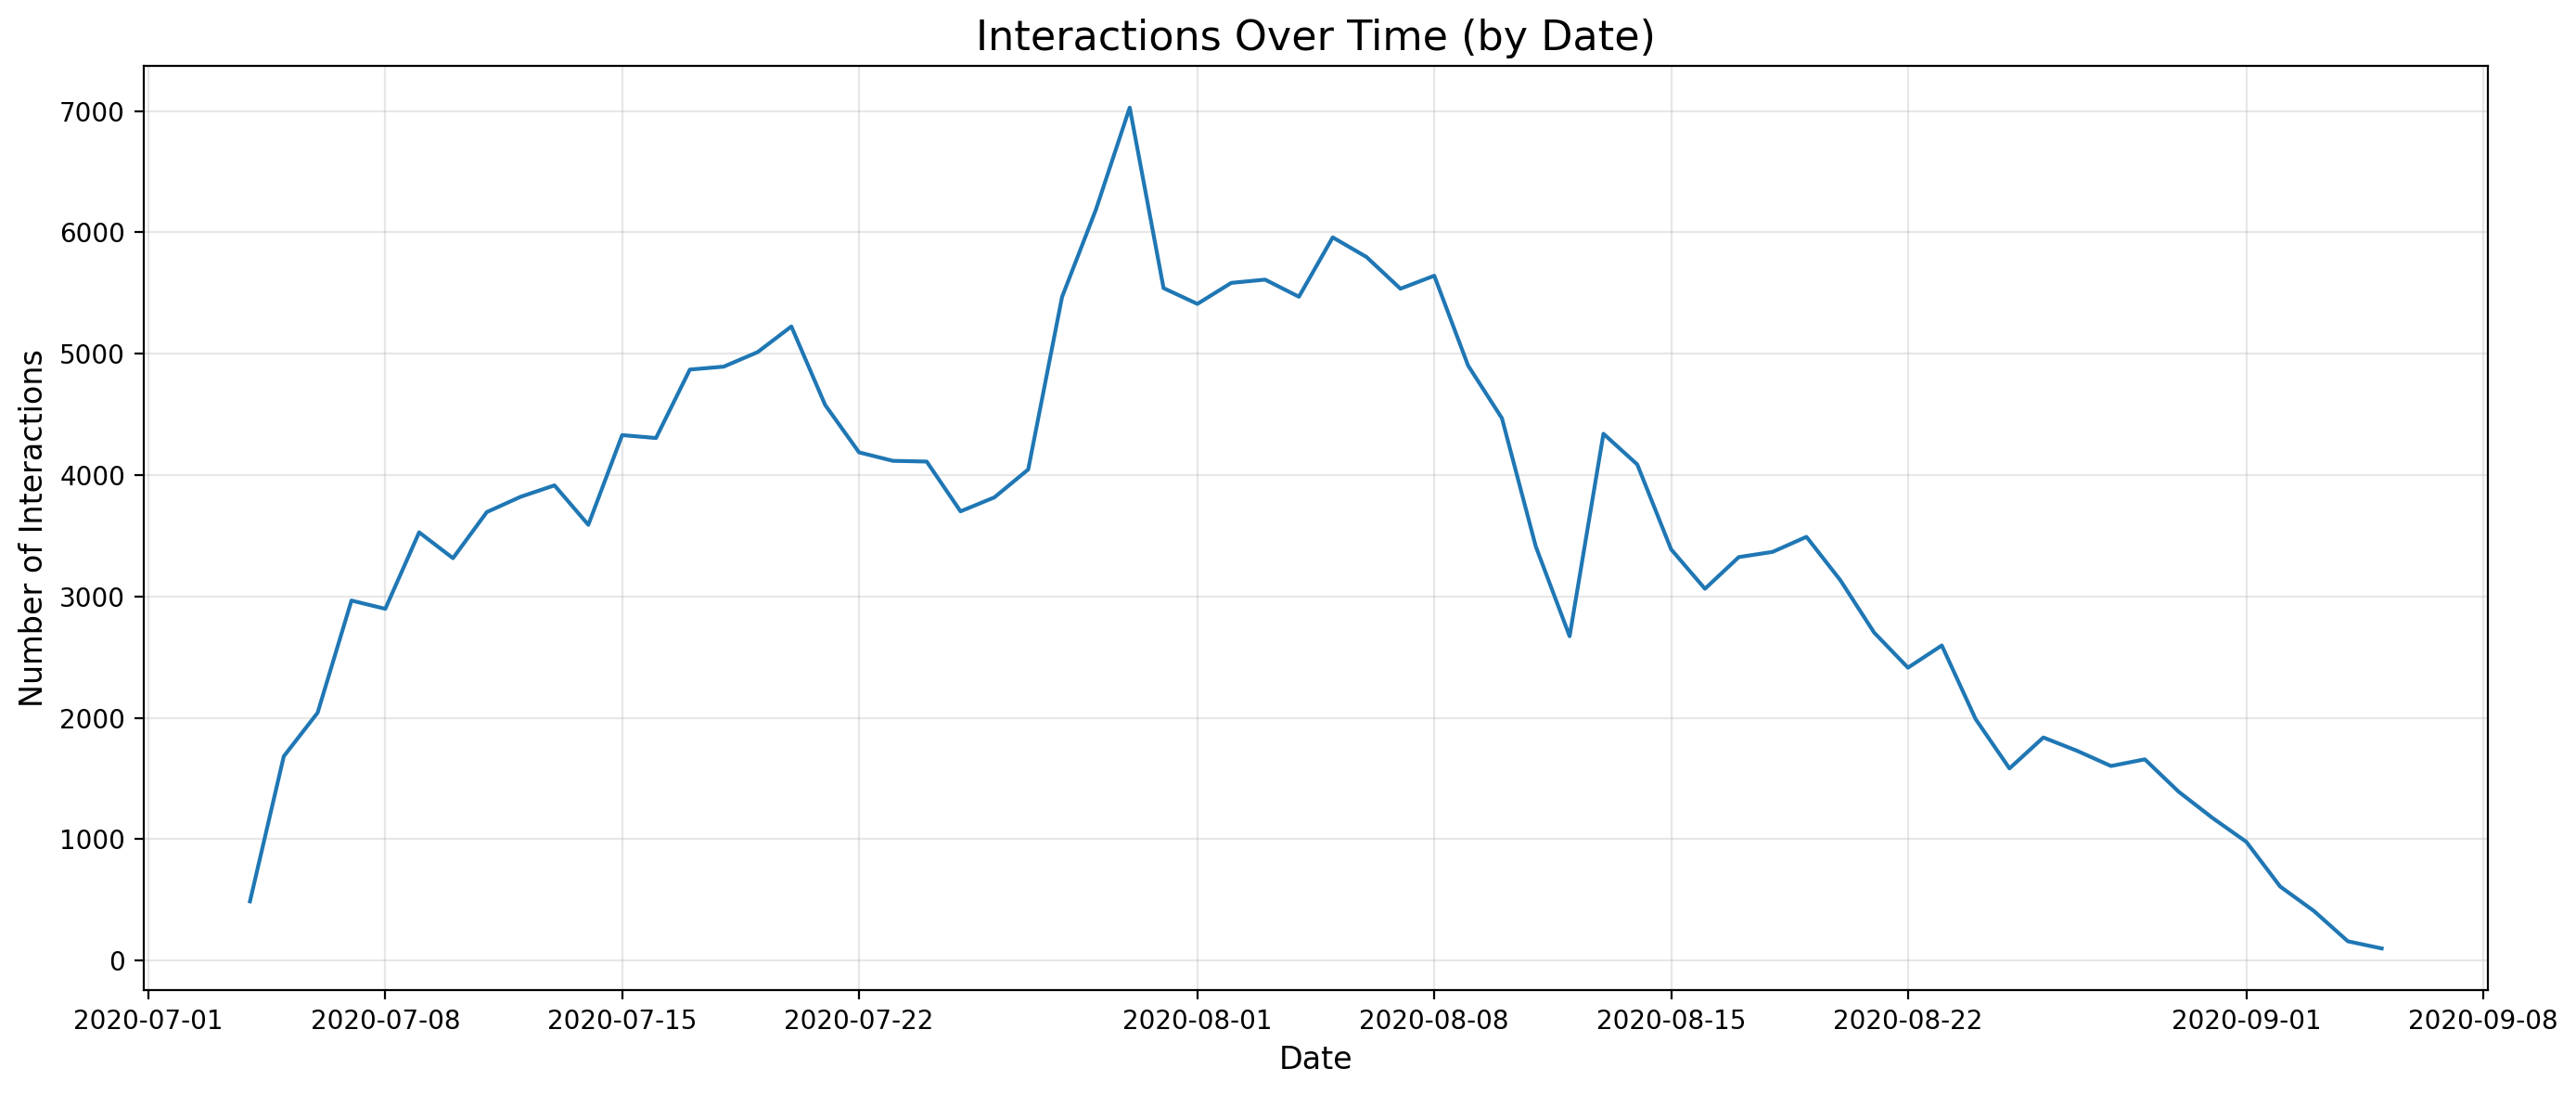

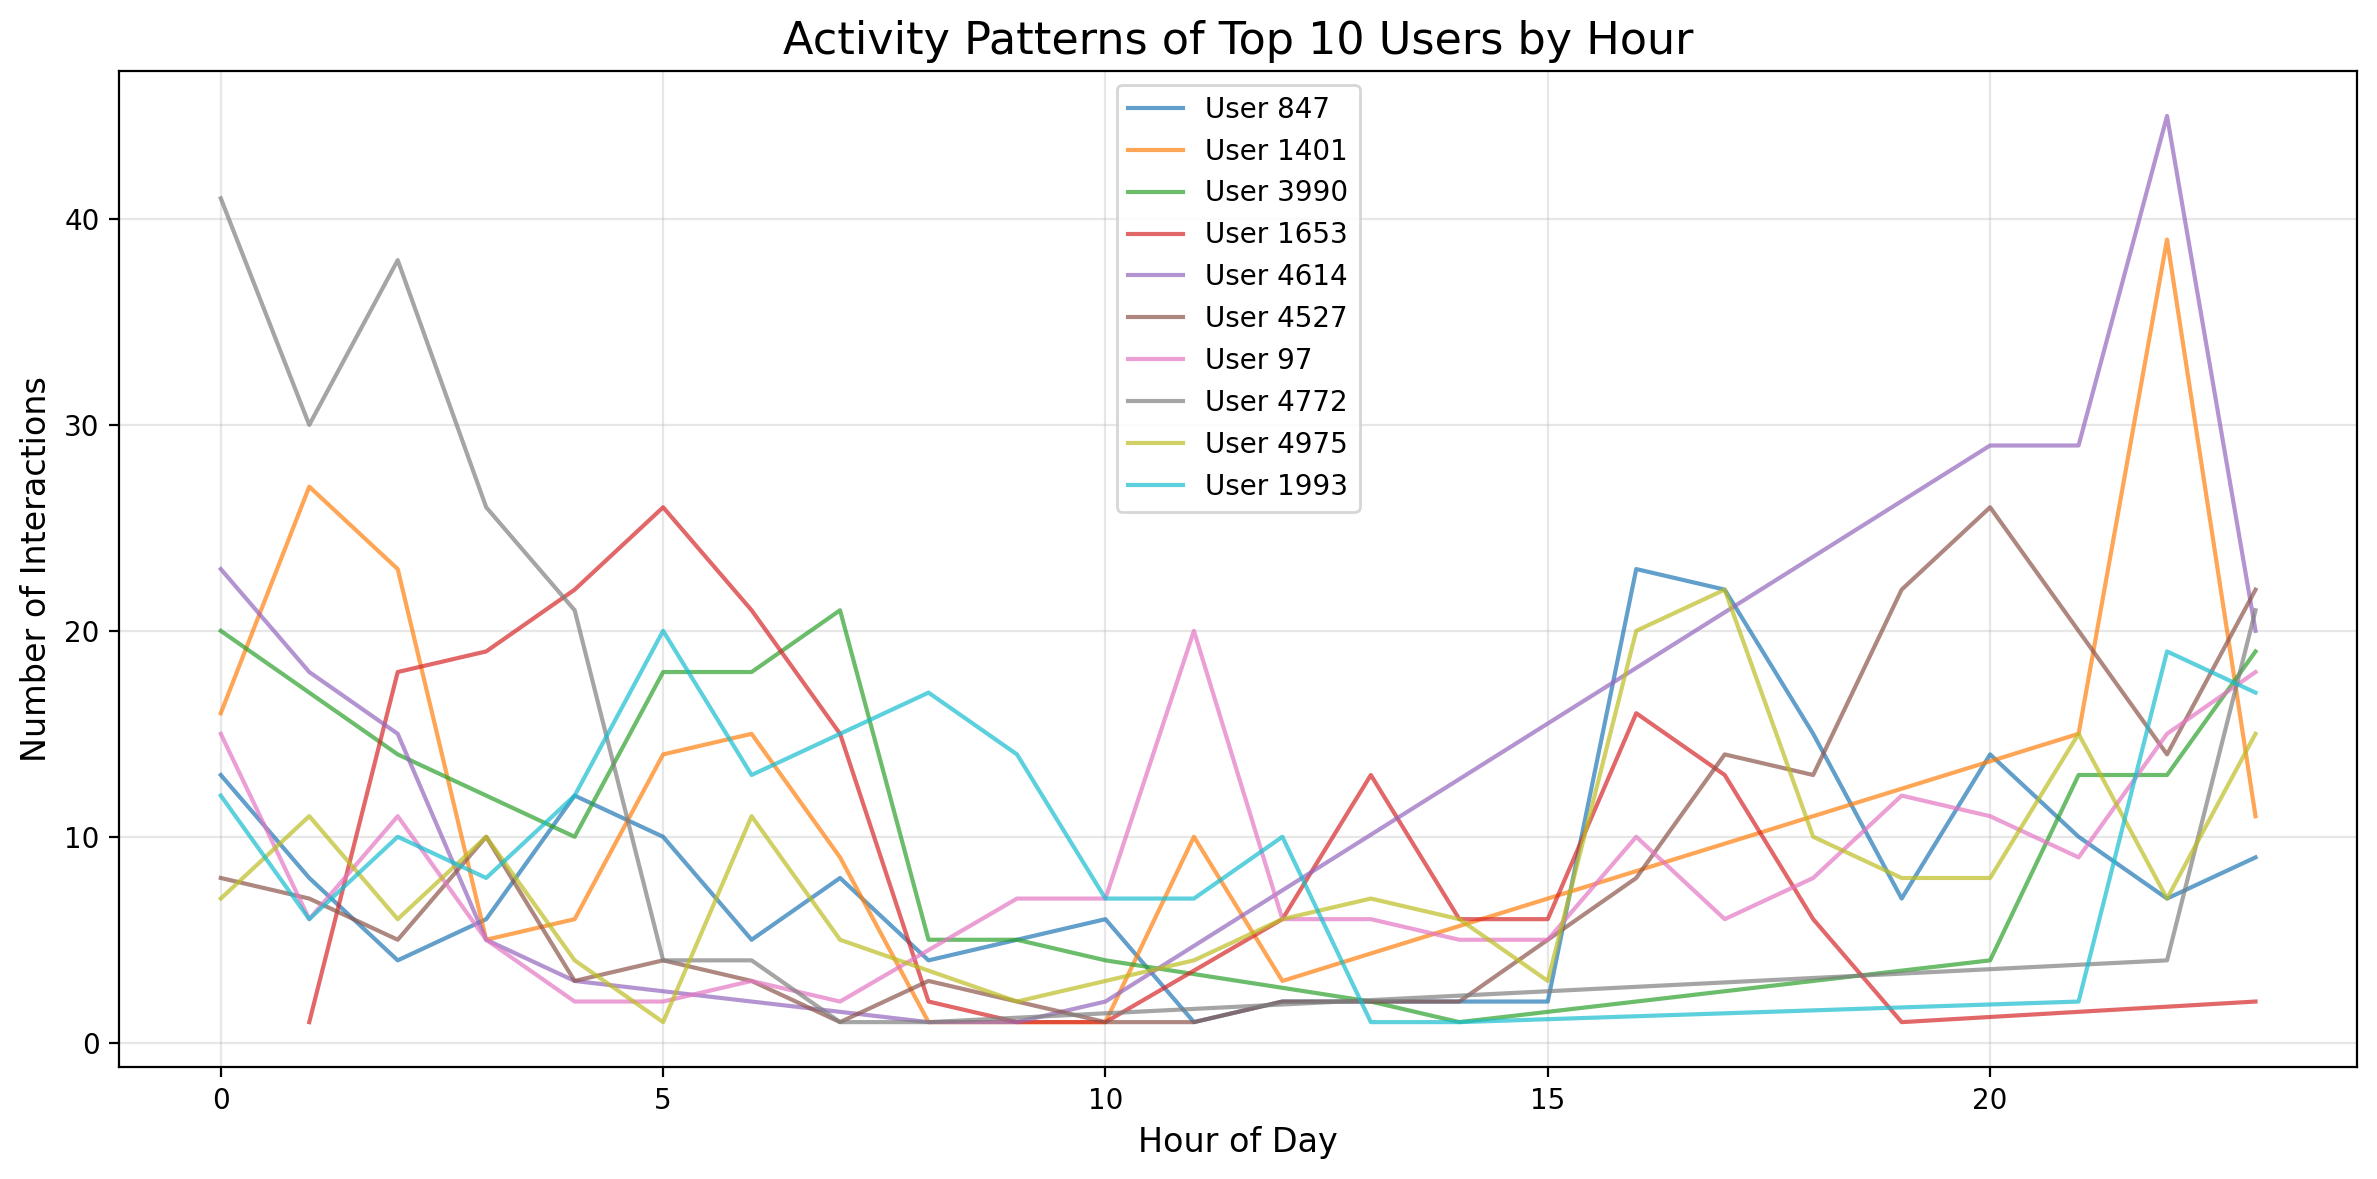


Peak Usage Hours:
Hour 0:00 - 12791 interactions
Hour 1:00 - 12724 interactions
Hour 2:00 - 12700 interactions

Peak Usage Days:
Thursday - 34383 interactions
Wednesday - 32169 interactions
Friday - 31921 interactions


In [ ]:
# Ensure all time columns are parsed correctly
small_matrix_pd["timestamp"] = pd.to_datetime(small_matrix_pd["timestamp"], errors="coerce", unit="s")
small_matrix_pd["date"] = pd.to_datetime(small_matrix_pd["date"], errors="coerce")
small_matrix_pd["time"] = pd.to_datetime(small_matrix_pd["time"], errors="coerce").dt.time

# Extract useful time features
small_matrix_pd["hour"] = small_matrix_pd["timestamp"].dt.hour
small_matrix_pd["weekday"] = small_matrix_pd["timestamp"].dt.dayofweek
small_matrix_pd["day"] = small_matrix_pd["timestamp"].dt.date

# Plot: Interactions by hour of day
plt.figure(figsize=(12, 6))
small_matrix_pd["hour"].value_counts().sort_index().plot(kind="bar", color="skyblue")
plt.title("Distribution of Activity by Hour", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Number of Interactions", fontsize=12)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Plot: Interactions by day of week
plt.figure(figsize=(10, 5))
weekday_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
small_matrix_pd["weekday"].value_counts().sort_index().plot(kind="bar", color="salmon")
plt.title("Distribution of Activity by Day of Week", fontsize=16)
plt.xlabel("Day of Week", fontsize=12)
plt.ylabel("Number of Interactions", fontsize=12)
plt.xticks(ticks=range(7), labels=weekday_labels)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Plot: Interactions over time (by date)
plt.figure(figsize=(14, 6))
small_matrix_pd["day"].value_counts().sort_index().plot()
plt.title("Interactions Over Time (by Date)", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of Interactions", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot: Activity patterns for top 10 users by hour
top_users = small_matrix_pd["user_id"].value_counts().head(10).index
plt.figure(figsize=(12, 6))
for user in top_users:
    user_data = small_matrix_pd[small_matrix_pd["user_id"] == user]
    user_data["hour"].value_counts().sort_index().plot(
        kind="line", alpha=0.7, label=f"User {user}"
    )
plt.title("Activity Patterns of Top 10 Users by Hour", fontsize=16)
plt.xlabel("Hour of Day", fontsize=12)
plt.ylabel("Number of Interactions", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Find and print peak usage times
hourly_activity = small_matrix_pd["hour"].value_counts().sort_index()
peak_hours = hourly_activity.nlargest(3)
print("\nPeak Usage Hours:")
for hour, count in peak_hours.items():
    print(f"Hour {hour}:00 - {count} interactions")

weekday_activity = small_matrix_pd["weekday"].value_counts().sort_index()
peak_days = weekday_activity.nlargest(3)
weekday_labels_full = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
print("\nPeak Usage Days:")
for day, count in peak_days.items():
    print(f"{weekday_labels_full[day]} - {count} interactions")

## Data Engineering
We will focus here on creating relevant data from the given raw data.

We will first try to binarize the categories. In the dataset, the categories are represented by a list which is not ideal for us.

In [54]:
from sklearn.preprocessing import MultiLabelBinarizer

category_binarizer = MultiLabelBinarizer()
categories_df = df_item_categories.toPandas()
categories_df["feat"] = categories_df["feat"].apply(eval)
category_matrix = category_binarizer.fit_transform(categories_df["feat"])
category_features = pd.DataFrame(
    category_matrix,
    columns=category_binarizer.classes_,
    index=categories_df["video_id"]
)
category_features.reset_index(drop=True, inplace=True)
category_features = category_features.astype("int16")
category_features.head(4)

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## Combining Like Ratio and Watch Ratio for Recommendations

To build a more effective recommender system, it is important to consider both how much time users spend watching a video (watch ratio) and how much they like the video (like ratio, calculated as the number of likes divided by the number of views). 

By using both metrics, we can recommend videos that are not only engaging (watched for longer) but also high quality (liked by many viewers). This approach helps ensure that recommendations are both relevant and enjoyable for users.

The first step is to aggregate the daily play and like counts for each video, so we can compute the overall like and view counts needed for the like ratio.

In [6]:
from pyspark.sql.functions import sum as spark_sum, col

agg = (
    df_item_daily_features
    .groupBy("video_id")
    .agg(
        spark_sum("like_cnt").alias("like_cnt"),
        spark_sum("play_cnt").alias("play_cnt")
    )
    .withColumn("like_ratio", col("like_cnt") / col("play_cnt"))
)

agg.show()

25/05/17 21:57:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------+--------+--------+--------------------+
|video_id|like_cnt|play_cnt|          like_ratio|
+--------+--------+--------+--------------------+
|     463|   12085|  680786|0.017751540131553823|
|     471|    6510|  565074|0.011520614999097463|
|     496|     103|    4734| 0.02175749894381073|
|     833|  379248| 5008877| 0.07571517527781177|
|    1829|    1007|  142304|0.007076399820103441|
|    1591|    3710|  404852|0.009163842589390691|
|    1959|       0|      44|                 0.0|
|    2142|       3|     119|0.025210084033613446|
|    2366|     701|   60316|0.011622123482989587|
|    2659|    3722|  588985|0.006319345993531245|
|    2866|     892|   80343|0.011102398466574561|
|    3749|       0|       9|                 0.0|
|    3918|   10886|  585443|0.018594466070992393|
|    4101|   33043| 4116890|0.008026204246409305|
|    4818|       0|     337|                 0.0|
|    5300|       6|     292| 0.02054794520547945|
|    5518|  313522| 3153007| 0.09943587185185443|


Now that we have calculated both the watch ratio and the like ratio for each video, we need to combine them into a single metric for training our ALS model. This is necessary because PySpark's ALS algorithm only accepts one rating column as input. To address this, we create a new column called `combined_ratio`, which merges the watch ratio and like ratio into a single value that reflects both user engagement and video quality.

In [16]:
WATCH_WEIGHT = 0.8
LIKE_WEIGHT = 1 - WATCH_WEIGHT


# Select only the relevant columns: user_id, video_id, and watch_ratio for the recommendation model
training = df_big_matrix.select("user_id", "video_id", "watch_ratio")
training.show(5)

test = df_small_matrix.select("user_id", "video_id", "watch_ratio")
test.show(5)

training = training.join(agg.select("video_id", "like_ratio"), on="video_id", how="left")
test = test.join(agg.select("video_id", "like_ratio"), on="video_id", how="left")

training = training.withColumn(
    "combined_ratio",
    WATCH_WEIGHT * col("watch_ratio") + LIKE_WEIGHT * col("like_ratio")
)
test = test.withColumn(
    "combined_ratio",
    WATCH_WEIGHT * col("watch_ratio") + LIKE_WEIGHT * col("like_ratio")
)


training = training.select("user_id", "video_id", "combined_ratio")
test = test.select("user_id", "video_id","combined_ratio")

training = training.dropna()
training = training.dropDuplicates()
test = test.dropna()
test = test.dropDuplicates()


training.show(5)
test.show(5)



+-------+--------+------------------+
|user_id|video_id|       watch_ratio|
+-------+--------+------------------+
|      0|    1986|1.5229745431498891|
|      0|    6834| 1.103753788761949|
|      0|    3722|0.1206527113894841|
|      0|    8295|1.9903230608902784|
|      0|    5257|               0.0|
+-------+--------+------------------+
only showing top 5 rows



+-------+--------+------------------+
|user_id|video_id|       watch_ratio|
+-------+--------+------------------+
|     14|    2201|1.1655538901757732|
|     14|    5537|0.7411229665908693|
|     14|    7155|0.5201354032917007|
|     14|    7029|1.0675439403699274|
|     14|    2039| 1.766717791411043|
+-------+--------+------------------+
only showing top 5 rows



+-------+--------+------------------+
|user_id|video_id|    combined_ratio|
+-------+--------+------------------+
|     71|    9852| 0.271416940413619|
|     83|    7340|0.7129034976663128|
|    161|   10206| 2.250182794982583|
|    170|    8592|0.9396007449385334|
|     15|    3918|1.0402491314548827|
+-------+--------+------------------+
only showing top 5 rows



+-------+--------+------------------+
|user_id|video_id|    combined_ratio|
+-------+--------+------------------+
|     14|   10206|1.6848284642739213|
|    172|     148|0.7704275424661463|
|    185|     463| 0.553054895182274|
|     97|     148| 1.346395895853323|
|    129|    7253|1.6247306365001961|
+-------+--------+------------------+
only showing top 5 rows



## System Recommender Training

We will now use ALS to train our recommender system. We use ALS because it is scalable, handles large and sparse user-item data efficiently, and is well-suited for collaborative filtering with implicit or explicit feedback. It is easy to use with PySpark and produces personalized recommendations for each user.

In [21]:
als = ALS(
    maxIter=10, 
    regParam=0.13,
    rank=30, 
    userCol="user_id", 
    itemCol="video_id", 
    ratingCol="combined_ratio",
    coldStartStrategy="drop",
    nonnegative=True,
)
model = als.fit(training)

## Model Evaluation

We use three regression metrics to evaluate the performance of our ALS recommender system on the test set:

- **RMSE (Root Mean Squared Error):** Measures the average magnitude of the prediction errors.
- **MAE (Mean Absolute Error):** Measures the average absolute difference between predicted and actual values.

The code below computes these metrics and displays a sample of the predictions.


In [22]:
evaluator_rmse = RegressionEvaluator(
    metricName="rmse", labelCol="combined_ratio", predictionCol="prediction"
)
evaluator_mae = RegressionEvaluator(
    metricName="mae", labelCol="combined_ratio", predictionCol="prediction"
)


predictions = model.transform(test)

rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

print(f"RMSE = {rmse:.4f}")
print(f"MAE  = {mae:.4f}")

predictions.show()

RMSE = 1.0690
MAE  = 0.2994


+-------+--------+-------------------+----------+
|user_id|video_id|     combined_ratio|prediction|
+-------+--------+-------------------+----------+
|     14|   10206| 1.6848284642739213| 1.3961555|
|    172|     148| 0.7704275424661463|  1.085595|
|    185|     463|  0.553054895182274|0.57319236|
|     97|     148|  1.346395895853323| 1.0110759|
|    129|    7253| 1.6247306365001961| 1.1368587|
|    140|     833| 0.6865430350555625| 0.7465816|
|     23|    8592|  0.534050110158492|0.84535456|
|    137|    9900|  0.763494230084964|  0.522148|
|    185|    9852| 0.6385593523799638| 0.2226148|
|    221|     471| 0.9099762541473606| 0.9750061|
|    226|     471| 1.1642713361145733|0.98300207|
|     73|    9852|0.16342067989632392|0.20031251|
|    328|     148| 0.5968986154841124| 1.0429344|
|    335|    6357|0.19116801000368192|  0.175711|
|    442|    9900| 2.0361497903051538|  0.701203|
|    534|    6357|0.08526286300679872|0.13751318|
|    297|    7880|0.16632761773157148|0.14272141|


### Interpretation of the results

- **RMSE = 1.0690**  

- **MAE = 0.2994**  



---

#### Interpretation
- The MAE is not extremely high, so the model is not completely off.
- The model is running and producing predictions without errors.
- However the RMSE is a bit high.


**Summary:**  
My model is making predictions, but accuracy is limited and it does not explain much of the variance.

## Recommendation

We can now finally get recommendations for the user. Just use the get_recommendations function to get the recommendations of a user.

In [50]:
K = 5
USERID = 14
def get_recommendations(user_id, model, K):
    # Create a DataFrame with the single user
    single_user_df = spark.createDataFrame([(user_id,)], ["user_id"])

    # Get top K recommendations for this user
    user_recs = model.recommendForUserSubset(single_user_df, K)
    user_recs.show(truncate=False)
    return user_recs

def get_recommendations_for_all_users(model, K):
    # Get top K recommendations for all users
    all_user_recs = model.recommendForAllUsers(K)
    all_user_recs.show(truncate=False)
    return all_user_recs

print(f"Recommendations for user {USERID}:")
get_recommendations(USERID, model, K)


Recommendations for user 14:
+-------+---------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                              |
+-------+---------------------------------------------------------------------------------------------+
|14     |[{6598, 33.11473}, {2406, 24.58832}, {2785, 13.328638}, {2767, 13.289155}, {4221, 13.285466}]|
+-------+---------------------------------------------------------------------------------------------+



DataFrame[user_id: int, recommendations: array<struct<video_id:int,rating:float>>]

## Another metric

Precision@10 measures the proportion of recommended items in the top 10 that are actually relevant to the user.  
Here we get around 0.7 which means that around 7 videos out of 10 are relevant for the users which is respectable.

In [51]:
from sklearn.metrics import precision_score
import numpy as np


def get_top_n_actual(user):
    user_interactions = test[test["user_id"] == user]
    top_items = user_interactions.sort(col("combined_ratio"), ascending=False).head(n)
    return top_items

def assess_recommendations(actual, predicted, user, topn):

    user_test_df = test[test["user_id"] == user]
    item_ids = user_test_df.select("video_id").rdd.flatMap(lambda x: x).collect()
    y_actual = np.array([[1 if vid in actual else 0 for vid in item_ids]])
    y_predicted = np.array([[1 if vid in predicted else 0 for vid in item_ids]])

    rank_map = {vid: 1 / (idx + 1) for idx, vid in enumerate(predicted)}
    y_rank = np.array([[rank_map.get(vid, 0) for vid in item_ids]])

    print(f"Precision@{topn}:", precision_score(y_actual[0], y_predicted[0], average="micro"))

def als_user_recommend(user):
    user_df = spark.createDataFrame([{"user_id": user}])
    recs = model.recommendForUserSubset(user_df, numItems=n).first()['recommendations']
    return recs

als_recs = als_user_recommend(USERID)
predicted_list = [rec.video_id for rec in als_recs]
actual_list = get_top_n_actual(USERID)
assess_recommendations(actual_list, predicted_list, USERID, 10)

Precision@10: 0.6768829475057059
